# Initializing

In [ ]:
!pip install torchinfo

from torchinfo import summary
import numpy as np
from tensorflow.keras.models import load_model
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import cv2 as cv
from scipy.linalg import hadamard
from scipy.ndimage import shift
import os
import torch


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%run '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/MyWatermarkinClasses.ipynb'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loaded Image

In [ ]:
## Test Images (Unseen Images)
#folder_path = '/content/drive/My Drive/Colab Notebooks/Image/COCO_Gray_Test_512'
folder_path = '/content/drive/My Drive/Colab Notebooks/Image/COCO_Gray_Validation_512'

test_image_array = []
#target_size = (128, 128)  # Resize to desired shape (width, height)

for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        img_path = os.path.join(folder_path, filename)
        my_image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        im = my_image.astype(np.float32)
        im = np.expand_dims(im, axis=-1)
        im = im / 255.0
        im = im[:,:,0]
        test_image_array.append(im)

# Hyper Parameters

In [ ]:
# Mask Ratio
mask_ratio = 0.5

# Watermarking Strength
G = 0.01

# ** Loaded Model

In [ ]:
# Define the path where the model is saved in Google Drive

# Shift Attack
#model_path = '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/Models/resnet18_4class_Shift_Attack.pth'


# Random Noise
# model_path = '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/Models/resnet18_4class_Random_Noise.pth'


# Guassian Noise
# model_path = '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/Models/resnet18_4class_Guassian_Noise.pth'


# Salt & Peper Noise
# model_path = '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/Models/resnet18_4class_Salt_Peper_Noise_Model6.pth'


# Blur Attack
# model_path = '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/Models/resnet18_4class_Blur_Attack.pth'


# Rotation Attack
# model_path = '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/Models/resnet18_4class_Rotation_Attack.pth'


# JPEG Attack
# model_path = '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/Models/resnet18_4class_JPEG_Attack_New.pth'


# Crop Attack
# model_path = '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/Models/resnet18_4class_Crop_Attack.pth'


# Brightness Attack
# model_path = '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/Models/resnet18_4class_brightness_Attack_Model2.pth'


# Contrast Attack
# model_path = '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/Models/resnet18_4class_contrast_Attack.pth'


# Universal Model _ For All Attacks
model_path = '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/Models/universal5_resnet18_4class.pth'


# # Load the model
# model = load_model(model_path)

# # Check the model architecture (optional)
# model.summary()


# Load the saved model
model = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)
model.eval()
summary(model, input_size=(1, 1, 128, 128))  # (batch_size, channels, height, width)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 4]                    --
├─Conv2d: 1-1                            [1, 64, 64, 64]           3,136
├─BatchNorm2d: 1-2                       [1, 64, 64, 64]           128
├─ReLU: 1-3                              [1, 64, 64, 64]           --
├─MaxPool2d: 1-4                         [1, 64, 32, 32]           --
├─Sequential: 1-5                        [1, 64, 32, 32]           --
│    └─BasicBlock: 2-1                   [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           128
│    │    └─ReLU: 3-3                    [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-4                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 32, 32]           128
│    │    └─ReLU: 3-6                    [1, 64, 32, 32]           --
│

# Complete Watermarking Process

## Splited Image

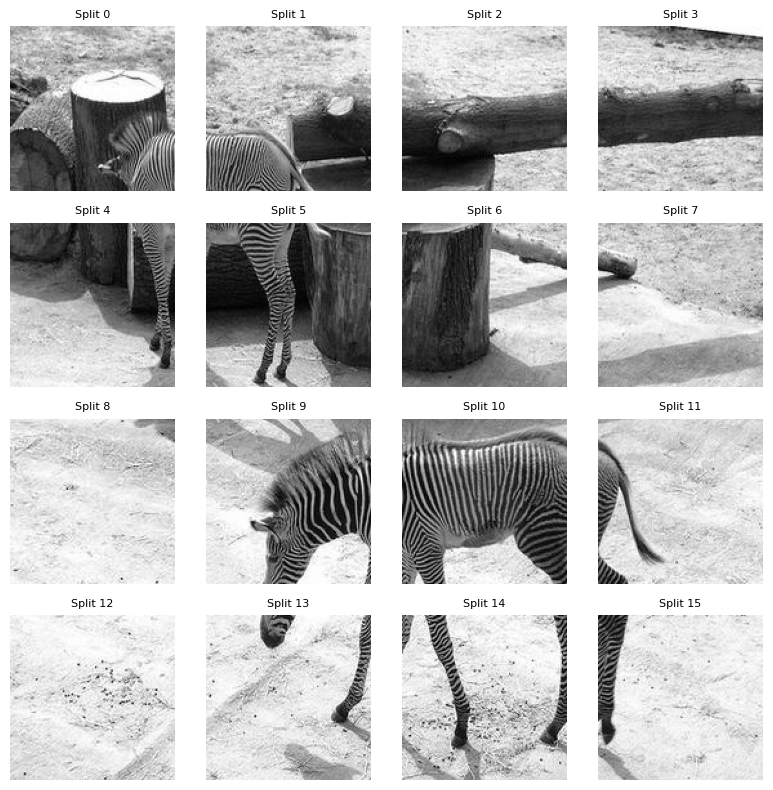

In [ ]:
def get_image_split(im, split_num):
    """
    Splits a 512x512 grayscale image into 16 (128x128) blocks and returns the specified block.

    Parameters:
    - image: 2D numpy array of shape (512, 512)
    - split_num: Integer in [0, 15], indicating which split to return

    Returns:
    - 2D numpy array of shape (128, 128)
    """
    if im.shape != (512, 512):
        raise ValueError("Image must be 512x512.")
    if not (0 <= split_num < 16):
        raise ValueError("split_num must be in range 0 to 15.")

    row = split_num // 4
    col = split_num % 4

    start_y = row * 128
    start_x = col * 128

    return im[start_y:start_y + 128, start_x:start_x + 128]

# Example usage
def show_all_splits(im):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(16):
        split = get_image_split(im, i)
        row = i // 4
        col = i % 4
        axes[row, col].imshow(split, cmap='gray')
        axes[row, col].axis('off')
        axes[row, col].set_title(f"Split {i}", fontsize=8)
    plt.tight_layout()
    plt.show()

_index = 4
show_all_splits(test_image_array[_index])

## Embedding

### Traditionals

In [ ]:
def complete_embedding(im, watermark_bits, method_flag):
    full_watermarked = np.zeros_like(im)
    pn_dict = {}

    for split_num in range(16):  # Splitting image into 4x4 = 16 blocks
        split_im = get_image_split(im, split_num)
        pn_creator = PNSequences(split_im)

        bit_pair = watermark_bits[2 * split_num : 2 * split_num + 2]

        if method_flag == 1:
            pn_array = pn_creator.created_traditional_pn_array()
            watermarked_block = Watermarking(split_im, bit_pair).embedding(G, pn_array)

        elif method_flag == 2:
            pn_array = pn_creator.created_hadamard_pn_array()
            watermarked_block = Watermarking(split_im, bit_pair).embedding(G, pn_array)

        elif method_flag == 3:
            pn_array = pn_creator.created_advanced_pn_array(G)
            watermarked_block = Watermarking(split_im, bit_pair).embedding(G, pn_array)

        elif method_flag == 4:
            pn_array = pn_creator.created_traditional_pn_array()
            watermarked_block = DCTWatermarking(split_im, bit_pair).embedding(G, pn_array)

        else:
            raise ValueError(f"Invalid method_flag: {method_flag}")

        # Store PN array used for this block
        pn_dict[split_num] = pn_array

        # Reconstruct full watermarked image
        row = split_num // 4
        col = split_num % 4
        start_y = row * 128
        start_x = col * 128

        full_watermarked[start_y:start_y + 128, start_x:start_x + 128] = watermarked_block

    return full_watermarked, pn_dict


### CNN-SSIS

In [ ]:
def complete_CNN_embedding(im, watermark_bits, mask_ratio):

  full_watermarked = np.zeros_like(im)  # same shape as im
  pn_dict = {}

  for split_num in range(16):  # 0 to 15 inclusive

    split_im = get_image_split(im, split_num)
    bit_pair = watermark_bits[2 * split_num : 2 * split_num + 2]

    watermarking = CNNWatermarking(split_im, mask_ratio)
    watermarked_block = watermarking.embedding(bit_pair)

    # Put watermarked block back into full image
    row = split_num // 4
    col = split_num % 4
    start_y = row * 128
    start_x = col * 128

    full_watermarked[start_y:start_y + 128, start_x:start_x + 128] = watermarked_block

  return full_watermarked

## Reconstruction

### Traditionals

In [ ]:
def complete_reconstruction(full_watermarked, pn_dict):

  reconstruction_bits = []

  for split_num in range(16):  # 0 to 15 inclusive

    split_watermarked = get_image_split(full_watermarked, split_num)
    bits = Watermarking(split_watermarked, None).reconstruction(pn_dict[split_num])
    reconstruction_bits.extend(bits.flatten())

  return np.array(reconstruction_bits)

### DCT

In [ ]:
def complete_dct_reconstruction(full_watermarked, pn_dict):

  reconstruction_bits = []

  for split_num in range(16):  # 0 to 15 inclusive

    split_watermarked = get_image_split(full_watermarked, split_num)
    bits = DCTWatermarking(split_watermarked, None).reconstruction(pn_dict[split_num])
    reconstruction_bits.extend(bits.flatten())

  return np.array(reconstruction_bits)

### CNN-SSIS

In [ ]:
def complete_CNN_reconstruction(full_watermarked, model):

  reconstruction_bits = []

  for split_num in range(16):  # 0 to 15 inclusive

    split_watermarked = get_image_split(full_watermarked, split_num)

    watermarking = CNNWatermarking(split_watermarked, mask_ratio)
    bits = watermarking.reconstruction(model)

    reconstruction_bits.extend(bits.flatten())

  return np.array(reconstruction_bits)

# Evaluation

In [ ]:
def calculate_ber(original_array, reconstructed_array):
    # Ensure the arrays are the same length
    if len(original_array) != len(reconstructed_array):
        raise ValueError("Arrays must have the same length")

    errors = np.sum(original_array != reconstructed_array)  # Count differing bits
    ber = errors / len(original_array)                      # BER = errors / total bits
    return ber


# === Plot ====
def plot_images(im, full_watermarked, noisy_watermarked):
  plt.figure(figsize=(15, 15))
  plt.subplot(1, 3, 1)
  plt.imshow(im, cmap='gray')
  plt.axis('off')
  plt.title('Original Image')
  plt.subplot(1, 3, 2)
  plt.imshow(full_watermarked, cmap='gray')
  plt.axis('off')
  plt.title('Watermarked Image')
  plt.subplot(1, 3, 3)
  plt.imshow(noisy_watermarked, cmap='gray')
  plt.axis('off')
  plt.title('Noisy Watermarked Image')
  plt.show()

## Noise

### Random Noise


Running experiment: Traditional-SSIS
→ Step 1/40 | Strength = 0.00 | Avg_BER = 12.00%
→ Step 2/40 | Strength = 0.10 | Avg_BER = 13.25%
→ Step 3/40 | Strength = 0.21 | Avg_BER = 12.94%
→ Step 4/40 | Strength = 0.31 | Avg_BER = 11.00%
→ Step 5/40 | Strength = 0.41 | Avg_BER = 11.06%
→ Step 6/40 | Strength = 0.51 | Avg_BER = 13.94%
→ Step 7/40 | Strength = 0.62 | Avg_BER = 12.31%
→ Step 8/40 | Strength = 0.72 | Avg_BER = 10.25%
→ Step 9/40 | Strength = 0.82 | Avg_BER = 12.31%
→ Step 10/40 | Strength = 0.92 | Avg_BER = 13.56%
→ Step 11/40 | Strength = 1.03 | Avg_BER = 12.19%
→ Step 12/40 | Strength = 1.13 | Avg_BER = 11.25%
→ Step 13/40 | Strength = 1.23 | Avg_BER = 14.88%
→ Step 14/40 | Strength = 1.33 | Avg_BER = 14.81%
→ Step 15/40 | Strength = 1.44 | Avg_BER = 13.56%
→ Step 16/40 | Strength = 1.54 | Avg_BER = 14.81%
→ Step 17/40 | Strength = 1.64 | Avg_BER = 16.06%
→ Step 18/40 | Strength = 1.74 | Avg_BER = 13.56%
→ Step 19/40 | Strength = 1.85 | Avg_BER = 16.38%
→ Step 20/40 | Streng

/tmp/ipython-input-802778055.py:85: RuntimeWarning: invalid value encountered in scalar divide
  my_cv = np.std(ber_list) / np.mean(ber_list)


→ Step 2/40 | Strength = 0.10 | Avg_BER = 0.00%
→ Step 3/40 | Strength = 0.21 | Avg_BER = 0.00%
→ Step 4/40 | Strength = 0.31 | Avg_BER = 0.47%
→ Step 5/40 | Strength = 0.41 | Avg_BER = 0.47%
→ Step 6/40 | Strength = 0.51 | Avg_BER = 0.62%
→ Step 7/40 | Strength = 0.62 | Avg_BER = 0.47%
→ Step 8/40 | Strength = 0.72 | Avg_BER = 0.62%
→ Step 9/40 | Strength = 0.82 | Avg_BER = 2.50%
→ Step 10/40 | Strength = 0.92 | Avg_BER = 2.97%
→ Step 11/40 | Strength = 1.03 | Avg_BER = 2.03%
→ Step 12/40 | Strength = 1.13 | Avg_BER = 5.47%
→ Step 13/40 | Strength = 1.23 | Avg_BER = 4.22%
→ Step 14/40 | Strength = 1.33 | Avg_BER = 5.31%
→ Step 15/40 | Strength = 1.44 | Avg_BER = 4.84%
→ Step 16/40 | Strength = 1.54 | Avg_BER = 4.38%
→ Step 17/40 | Strength = 1.64 | Avg_BER = 6.88%
→ Step 18/40 | Strength = 1.74 | Avg_BER = 7.81%
→ Step 19/40 | Strength = 1.85 | Avg_BER = 8.75%
→ Step 20/40 | Strength = 1.95 | Avg_BER = 9.22%
→ Step 21/40 | Strength = 2.05 | Avg_BER = 9.84%
→ Step 22/40 | Strength = 2.

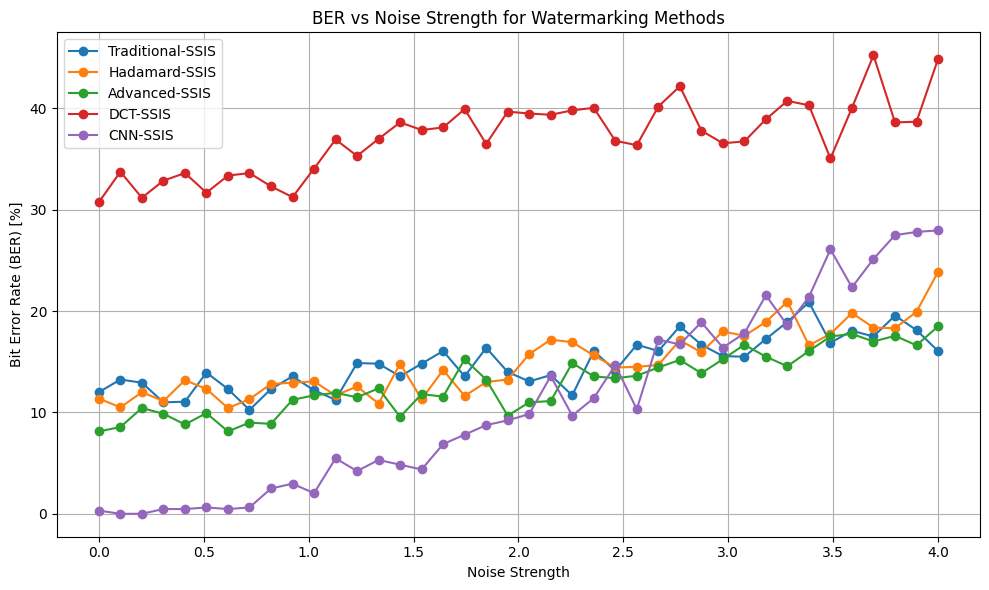

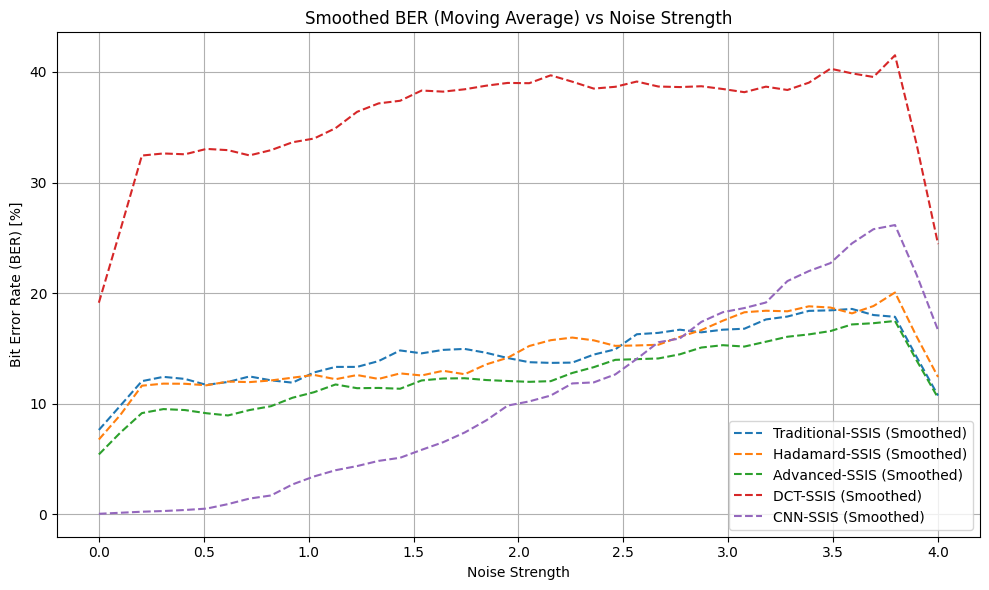

In [ ]:
# Parameters
iterations = 50
cnn_iterations = 20
noise_strength_values = np.linspace(0, 4, 40)  # Noise from 0 to 4

# iterations = 1
# cnn_iterations = 2
# noise_strength_values = np.linspace(0, 4, 40)

ber_results = {
    "Traditional-SSIS": [],
    "Hadamard-SSIS": [],
    "Advanced-SSIS": [],
    "DCT-SSIS": [],
    "CNN-SSIS": []
}

# === SSIS METHODS (1: Traditional, 2: Hadamard, 3: Advanced, 4: DCT-SSIS) ===
for method_flag, method_name in zip([1, 2, 3, 4], list(ber_results.keys())[:4]):
    print(f"\nRunning experiment: {method_name}")

    for idx, noise_strength in enumerate(noise_strength_values):
        total_ber = 0

        for i in range(iterations):
            print(f"     Iteration {i+1}/{iterations}", end='\r')
            watermark_bits = np.random.choice([0, 1], size=32)

            # Select random image
            index = np.random.randint(0, len(test_image_array))
            im = test_image_array[index]

            # Embedding
            full_watermarked, pn_dict = complete_embedding(im, watermark_bits, method_flag)

            # Simulate transmission through noisy channel
            channel = Channel(full_watermarked)
            noisy_watermarked = channel.add_random_noise(noise_strength)

            # Reconstruction based on method
            if method_flag == 4:
                reconstruction_bits = complete_dct_reconstruction(noisy_watermarked, pn_dict)
            else:
                reconstruction_bits = complete_reconstruction(noisy_watermarked, pn_dict)

            # Calculate BER
            total_ber += calculate_ber(watermark_bits, reconstruction_bits)

        avg_ber = total_ber / iterations
        ber_results[method_name].append(avg_ber)
        print(f"→ Step {idx+1}/{len(noise_strength_values)} | Strength = {noise_strength:.2f} | Avg_BER = {avg_ber * 100:.2f}%")

# === CNN-BASED METHOD ===
print(f"\nRunning experiment: CNN-Based")
cv_results = []  # To store CV for each noise_strength

for idx, noise_strength in enumerate(noise_strength_values):
    total_ber = 0
    ber_list = []  # Store BERs for each iteration


    for i in range(cnn_iterations):
        print(f"     Iteration {i+1}/{cnn_iterations}", end='\r')
        watermark_bits = np.random.choice([0, 1], size=32)

        index = np.random.randint(0, len(test_image_array))
        im = test_image_array[index]

        full_watermarked = complete_CNN_embedding(im, watermark_bits, mask_ratio)

        # Channel
        channel = Channel(full_watermarked)
        noisy_watermarked = channel.add_random_noise(noise_strength)

        reconstruction_bits = complete_CNN_reconstruction(noisy_watermarked, model)
        ber = calculate_ber(watermark_bits, reconstruction_bits)
        ber_list.append(ber)
        total_ber += ber

    avg_ber = total_ber / cnn_iterations
    ber_results["CNN-SSIS"].append(avg_ber)

    # Compute coefficient of variation for this noise strength
    # print(ber_list)
    my_cv = np.std(ber_list) / np.mean(ber_list)
    # print(f"cv: {my_cv}")
    if not np.isnan(my_cv):
      cv_results.append(my_cv)

    print(f"→ Step {idx+1}/{len(noise_strength_values)} | Strength = {noise_strength:.2f} | Avg_BER = {avg_ber * 100:.2f}%")

avg_cv = np.mean(cv_results)
print(f"\nAverage Coefficient of Variation over all noise strengths: {avg_cv:.4f}")

# === ORIGINAL BER PLOT ===
plt.figure(figsize=(10, 6))
for method_name, ber_list in ber_results.items():
    plt.plot(noise_strength_values, np.array(ber_list) * 100, label=method_name, marker='o')

plt.title("BER vs Noise Strength for Watermarking Methods")
plt.xlabel("Noise Strength")
plt.ylabel("Bit Error Rate (BER) [%]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# === MOVING AVERAGE BER PLOT ===
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

plt.figure(figsize=(10, 6))
window_size = 5  # Can be adjusted (e.g., 3 or 7)
for method_name, ber_list in ber_results.items():
    smoothed = moving_average(np.array(ber_list) * 100, window_size)
    plt.plot(noise_strength_values, smoothed, label=f"{method_name} (Smoothed)", linestyle='--')

plt.title("Smoothed BER (Moving Average) vs Noise Strength")
plt.xlabel("Noise Strength")
plt.ylabel("Bit Error Rate (BER) [%]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


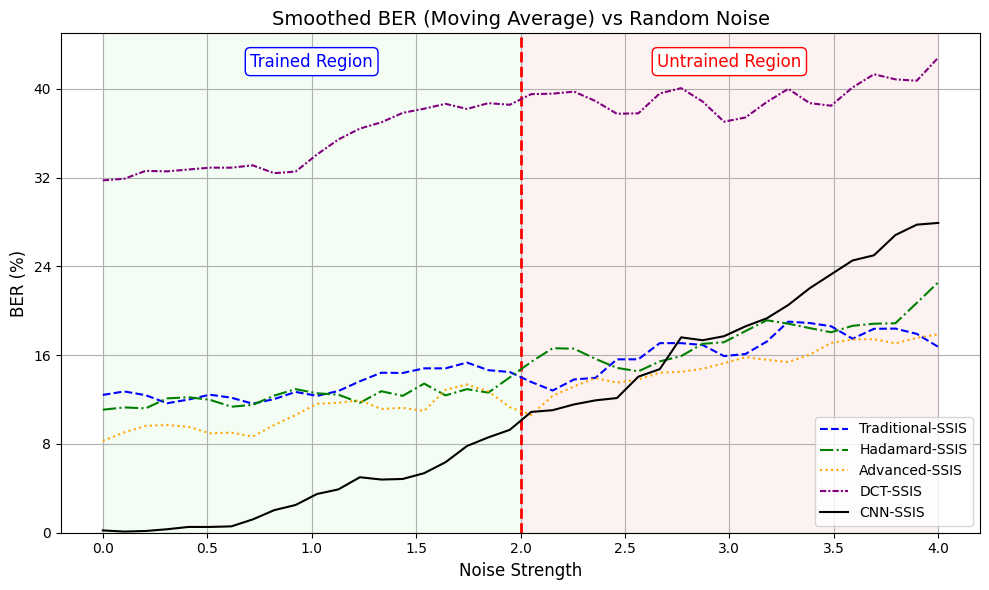

In [ ]:
from matplotlib.ticker import MaxNLocator

# Modified moving average with edge padding to keep length and edges accurate
def moving_average(data, window_size=5):
    pad = window_size // 2
    padded = np.pad(data, (pad, pad), mode='edge')  # pad edges with nearest value to avoid shrinking
    return np.convolve(padded, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(10, 6))
window_size = 3

line_styles = ['--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'green', 'orange', 'purple', 'teal']

# Background color regions
plt.axvspan(min(noise_strength_values), 2, color='lightgreen', alpha=0.1, label='_nolegend_')   # Trained
plt.axvspan(2, max(noise_strength_values), color='lightcoral', alpha=0.1, label='_nolegend_')  # Untrained

# Vertical separation line at Noise Strength = 2
plt.axvline(x=2, color='red', linestyle='--', linewidth=2)

# Plot smoothed curves for each method over full range
for i, (method_name, ber_list) in enumerate(ber_results.items()):
    smoothed = moving_average(np.array(ber_list) * 100, window_size)

    if "cnn" in method_name.lower():
        linestyle = '-'
        color = 'black'
    else:
        linestyle = line_styles[i % len(line_styles)]
        color = colors[i % len(colors)]

    plt.plot(noise_strength_values, smoothed, label=method_name, linestyle=linestyle, color=color)

# Use MaxNLocator for coarser grid ticks
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=9))  # ~9 ticks on x-axis
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=6))  # ~6 ticks on y-axis

# Set fixed Y-axis range to 0-45
plt.ylim(0, 45)

# Region labels inside plot, moved lower to fit the smaller y-limit
plt.text(1.0, 42, "Trained Region", ha='center', fontsize=12, color='blue',
         bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.3'))

plt.text((2 + max(noise_strength_values)) / 2, 42, "Untrained Region", ha='center', fontsize=12, color='red',
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))

# Final formatting
plt.title("Smoothed BER (Moving Average) vs Random Noise", fontsize=14)
plt.xlabel("Noise Strength", fontsize=12)
plt.ylabel("BER (%)", fontsize=12)
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### Guassian Noise

In [ ]:
# Parameters
iterations = 50
cnn_iterations = 20
standard_deviation_values = np.linspace(0, 2.1, 40)  # Noise from 0 to 1
ber_results = {
    "Traditional-SSIS": [],
    "Hadamard-SSIS": [],
    "Advanced-SSIS": [],
    "DCT-SSIS": [],      # Added DCT-SSIS here
    "CNN-SSIS": []
}

# === SSIS METHODS (1: Traditional, 2: Hadamard, 3: Advanced, 4: DCT-SSIS) ===
for method_flag, method_name in zip([1, 2, 3, 4], list(ber_results.keys())[:4]):
    print(f"\nRunning experiment: {method_name}")

    for idx, standard_deviation in enumerate(standard_deviation_values):
        total_ber = 0

        for i in range(iterations):
            print(f"     Iteration {i+1}/{iterations}", end='\r')
            watermark_bits = np.random.choice([0, 1], size=32)

            index = np.random.randint(0, len(test_image_array))
            im = test_image_array[index]

            full_watermarked, pn_dict = complete_embedding(im, watermark_bits, method_flag)

            # Channel
            channel = Channel(full_watermarked)
            noisy_watermarked = channel.add_guassian_noise(0, standard_deviation)

            # Reconstruction differs for DCT-SSIS
            if method_flag == 4:
                reconstruction_bits = complete_dct_reconstruction(noisy_watermarked, pn_dict)
            else:
                reconstruction_bits = complete_reconstruction(noisy_watermarked, pn_dict)

            total_ber += calculate_ber(watermark_bits, reconstruction_bits)

        avg_ber = total_ber / iterations
        ber_results[method_name].append(avg_ber)
        print(f"→ Step {idx+1}/{len(standard_deviation_values)} | Std = {standard_deviation:.2f} | Avg_BER = {avg_ber * 100:.2f}%")

# === CNN-BASED METHOD ===
print(f"\nRunning experiment: CNN-Based")
for idx, standard_deviation in enumerate(standard_deviation_values):
    total_ber = 0

    for i in range(cnn_iterations):
        print(f"     Iteration {i+1}/{cnn_iterations}", end='\r')
        watermark_bits = np.random.choice([0, 1], size=32)

        index = np.random.randint(0, len(test_image_array))
        im = test_image_array[index]

        full_watermarked = complete_CNN_embedding(im, watermark_bits, mask_ratio)

        # Channel
        channel = Channel(full_watermarked)
        noisy_watermarked = channel.add_guassian_noise(0, standard_deviation)

        reconstruction_bits = complete_CNN_reconstruction(noisy_watermarked, model)
        total_ber += calculate_ber(watermark_bits, reconstruction_bits)

    avg_ber = total_ber / cnn_iterations
    ber_results["CNN-SSIS"].append(avg_ber)
    print(f"→ Step {idx+1}/{len(standard_deviation_values)} | Std = {standard_deviation:.2f} | Avg_BER = {avg_ber * 100:.2f}%")

# === PLOTTING ORIGINAL BER ===
plt.figure(figsize=(10, 6))
for method_name, ber_list in ber_results.items():
    plt.plot(standard_deviation_values, np.array(ber_list) * 100, label=method_name, marker='o')
plt.title("BER vs Standard Deviation for Watermarking Methods")
plt.xlabel("Standard Deviation")
plt.ylabel("Bit Error Rate (BER) [%]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === PLOTTING MOVING AVERAGE ===
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

plt.figure(figsize=(10, 6))
window_size = 5  # you can adjust this
for method_name, ber_list in ber_results.items():
    smoothed_ber = moving_average(np.array(ber_list) * 100, window_size)
    plt.plot(standard_deviation_values, smoothed_ber, label=f"{method_name} (Smoothed)", linestyle='--')
plt.title("Smoothed BER (Moving Average) vs Standard Deviation")
plt.xlabel("Standard Deviation")
plt.ylabel("Bit Error Rate (BER) [%]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Running experiment: Traditional-SSIS
→ Step 1/40 | Std = 0.00 | Avg_BER = 3.12%
→ Step 2/40 | Std = 0.05 | Avg_BER = 6.25%
→ Step 3/40 | Std = 0.11 | Avg_BER = 15.62%
→ Step 4/40 | Std = 0.16 | Avg_BER = 6.25%
→ Step 5/40 | Std = 0.22 | Avg_BER = 6.25%
→ Step 6/40 | Std = 0.27 | Avg_BER = 6.25%
→ Step 7/40 | Std = 0.32 | Avg_BER = 12.50%
→ Step 8/40 | Std = 0.38 | Avg_BER = 9.38%
→ Step 9/40 | Std = 0.43 | Avg_BER = 15.62%
→ Step 10/40 | Std = 0.48 | Avg_BER = 9.38%
→ Step 11/40 | Std = 0.54 | Avg_BER = 3.12%
→ Step 12/40 | Std = 0.59 | Avg_BER = 12.50%
→ Step 13/40 | Std = 0.65 | Avg_BER = 21.88%
→ Step 14/40 | Std = 0.70 | Avg_BER = 31.25%
→ Step 15/40 | Std = 0.75 | Avg_BER = 12.50%
→ Step 16/40 | Std = 0.81 | Avg_BER = 6.25%
→ Step 17/40 | Std = 0.86 | Avg_BER = 18.75%
→ Step 18/40 | Std = 0.92 | Avg_BER = 21.88%
→ Step 19/40 | Std = 0.97 | Avg_BER = 12.50%
→ Step 20/40 | Std = 1.02 | Avg_BER = 21.88%
→ Step 21/40 | Std = 1.08 | Avg_BER = 21.88%
→ Step 22/40 | Std = 1.13 | Avg_BER

KeyboardInterrupt: 

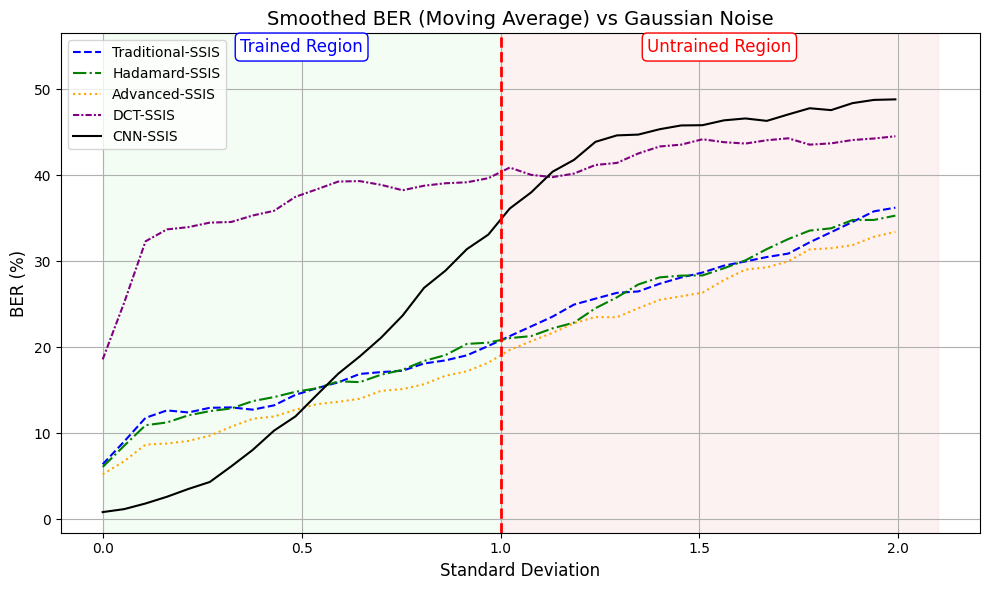

In [ ]:
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

plt.figure(figsize=(10, 6))
window_size = 5
cut = window_size // 2  # to avoid trailing artifacts

# Line styles and colors
line_styles = ['--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'green', 'orange', 'purple', 'teal']

# Plot each method
for i, (method_name, ber_list) in enumerate(ber_results.items()):
    smoothed = moving_average(np.array(ber_list) * 100, window_size)

    if "cnn" in method_name.lower():
        linestyle = '-'
        color = 'black'
    else:
        linestyle = line_styles[i % len(line_styles)]
        color = colors[i % len(colors)]

    plt.plot(standard_deviation_values[:-cut], smoothed[:-cut], label=method_name, linestyle=linestyle, color=color)

# Add very light shaded regions
plt.axvspan(0, 1, color='lightgreen', alpha=0.1, label='_nolegend_')        # Trained
plt.axvspan(1, max(standard_deviation_values), color='lightcoral', alpha=0.1, label='_nolegend_')  # Untrained

# Add solid vertical red line at standard deviation = 1
plt.axvline(x=1, color='red', linestyle='--', linewidth=2)

# Add region labels above
ymin, ymax = plt.ylim()
xmid_left = (0 + 1) / 2
xmid_right = (1 + max(standard_deviation_values)) / 2
label_y = ymax + (ymax - ymin) * 0.05

plt.text(xmid_left, label_y, "Trained Region", ha='center', va='bottom', fontsize=12, color='blue',
         bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.3'))

plt.text(xmid_right, label_y, "Untrained Region", ha='center', va='bottom', fontsize=12, color='red',
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))

# Extend ylim to fit labels
plt.ylim(ymin, label_y + (ymax - ymin) * 0.05)

# Add titles and labels with bold style
plt.title("Smoothed BER (Moving Average) vs Gaussian Noise", fontsize=14)
plt.xlabel("Standard Deviation", fontsize=12)
plt.ylabel("BER (%)", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Salt & Peper Noise


Running Salt and Pepper noise attack experiment: Traditional-SSIS
→ Step 1/40 | Noise Ratio = 0.010 | Avg_BER = 9.69%
→ Step 2/40 | Noise Ratio = 0.011 | Avg_BER = 12.50%
→ Step 3/40 | Noise Ratio = 0.012 | Avg_BER = 12.81%
→ Step 4/40 | Noise Ratio = 0.013 | Avg_BER = 10.00%
→ Step 5/40 | Noise Ratio = 0.014 | Avg_BER = 13.12%
→ Step 6/40 | Noise Ratio = 0.015 | Avg_BER = 10.00%
→ Step 7/40 | Noise Ratio = 0.016 | Avg_BER = 14.37%
→ Step 8/40 | Noise Ratio = 0.017 | Avg_BER = 9.69%
→ Step 9/40 | Noise Ratio = 0.018 | Avg_BER = 10.62%
→ Step 10/40 | Noise Ratio = 0.019 | Avg_BER = 13.75%
→ Step 11/40 | Noise Ratio = 0.020 | Avg_BER = 17.19%
→ Step 12/40 | Noise Ratio = 0.021 | Avg_BER = 15.94%
→ Step 13/40 | Noise Ratio = 0.022 | Avg_BER = 13.44%
→ Step 14/40 | Noise Ratio = 0.023 | Avg_BER = 15.00%
→ Step 15/40 | Noise Ratio = 0.024 | Avg_BER = 12.50%
→ Step 16/40 | Noise Ratio = 0.025 | Avg_BER = 12.19%
→ Step 17/40 | Noise Ratio = 0.026 | Avg_BER = 14.06%
→ Step 18/40 | Noise Ratio

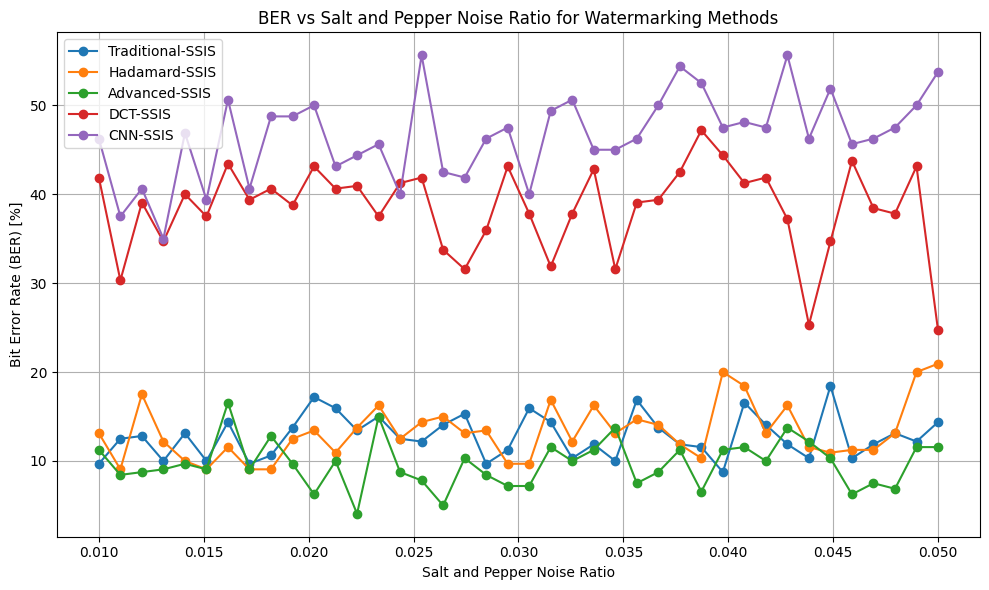

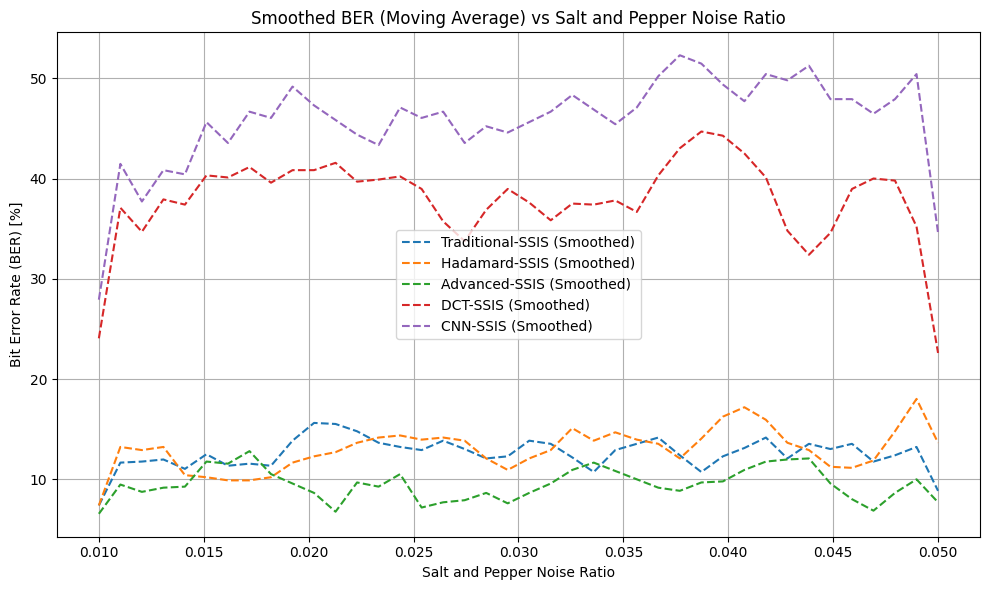

In [ ]:
# Parameters
iterations = 10
cnn_iterations = 5

noise_ratios = np.linspace(0.01, 0.05, 40)  # Noise ratios from 0 to 0.1 (10%) in 9 steps
ber_results = {
    "Traditional-SSIS": [],
    "Hadamard-SSIS": [],
    "Advanced-SSIS": [],
    "DCT-SSIS": [],
    "CNN-SSIS": []
}

# === SSIS METHODS (1: Traditional, 2: Hadamard, 3: Advanced, 4: DCT-SSIS) ===
for method_flag, method_name in zip([1, 2, 3, 4], list(ber_results.keys())[:4]):
    print(f"\nRunning Salt and Pepper noise attack experiment: {method_name}")

    for idx, noise_ratio in enumerate(noise_ratios):
        total_ber = 0

        for i in range(iterations):
            print(f"     Iteration {i+1}/{iterations}", end='\r')
            watermark_bits = np.random.choice([0, 1], size=32)

            index = np.random.randint(0, len(test_image_array))
            im = test_image_array[index]

            full_watermarked, pn_dict = complete_embedding(im, watermark_bits, method_flag)

            # Channel
            channel = Channel(full_watermarked)
            noisy_watermarked = channel.add_salt_and_pepper_noise(noise_ratio)

            # Reconstruction based on method
            if method_flag == 4:
                reconstruction_bits = complete_dct_reconstruction(noisy_watermarked, pn_dict)
            else:
                reconstruction_bits = complete_reconstruction(noisy_watermarked, pn_dict)

            total_ber += calculate_ber(watermark_bits, reconstruction_bits)

        avg_ber = total_ber / iterations
        ber_results[method_name].append(avg_ber)
        print(f"→ Step {idx+1}/{len(noise_ratios)} | Noise Ratio = {noise_ratio:.3f} | Avg_BER = {avg_ber * 100:.2f}%")


# === CNN-BASED METHOD ===
print(f"\nRunning Salt and Pepper noise attack experiment: CNN-Based")
for idx, noise_ratio in enumerate(noise_ratios):
    total_ber = 0

    for i in range(cnn_iterations):
        print(f"     Iteration {i+1}/{cnn_iterations}", end='\r')
        watermark_bits = np.random.choice([0, 1], size=32)

        index = np.random.randint(0, len(test_image_array))
        im = test_image_array[index]

        full_watermarked = complete_CNN_embedding(im, watermark_bits, mask_ratio)

        # Channel
        channel = Channel(full_watermarked)
        noisy_watermarked = channel.add_salt_and_pepper_noise(noise_ratio)

        reconstruction_bits = complete_CNN_reconstruction(noisy_watermarked, model)
        total_ber += calculate_ber(watermark_bits, reconstruction_bits)

    avg_ber = total_ber / cnn_iterations
    ber_results["CNN-SSIS"].append(avg_ber)
    print(f"→ Step {idx+1}/{len(noise_ratios)} | Noise Ratio = {noise_ratio:.3f} | Avg_BER = {avg_ber * 100:.2f}%")


# === BER PLOT ===
plt.figure(figsize=(10, 6))
for method_name, ber_list in ber_results.items():
    plt.plot(noise_ratios, np.array(ber_list) * 100, label=method_name, marker='o')

plt.title("BER vs Salt and Pepper Noise Ratio for Watermarking Methods")
plt.xlabel("Salt and Pepper Noise Ratio")
plt.ylabel("Bit Error Rate (BER) [%]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# === SMOOTHED BER PLOT ===
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

plt.figure(figsize=(10, 6))
window_size = 3
for method_name, ber_list in ber_results.items():
    smoothed = moving_average(np.array(ber_list) * 100, window_size)
    plt.plot(noise_ratios, smoothed, label=f"{method_name} (Smoothed)", linestyle='--')

plt.title("Smoothed BER (Moving Average) vs Salt and Pepper Noise Ratio")
plt.xlabel("Salt and Pepper Noise Ratio")
plt.ylabel("Bit Error Rate (BER) [%]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Filter

### Blur Attack


Running experiment: Traditional-SSIS
→ Step 1/10 | Filter Size = 1 | Avg_BER = 3.12%
→ Step 2/10 | Filter Size = 2 | Avg_BER = 50.00%
→ Step 3/10 | Filter Size = 3 | Avg_BER = 40.62%
→ Step 4/10 | Filter Size = 4 | Avg_BER = 46.88%
→ Step 5/10 | Filter Size = 5 | Avg_BER = 56.25%
→ Step 6/10 | Filter Size = 6 | Avg_BER = 50.00%
→ Step 7/10 | Filter Size = 7 | Avg_BER = 50.00%
→ Step 8/10 | Filter Size = 8 | Avg_BER = 46.88%
→ Step 9/10 | Filter Size = 9 | Avg_BER = 71.88%
→ Step 10/10 | Filter Size = 10 | Avg_BER = 46.88%

Running experiment: Hadamard-SSIS
→ Step 1/10 | Filter Size = 1 | Avg_BER = 6.25%
→ Step 2/10 | Filter Size = 2 | Avg_BER = 34.38%
→ Step 3/10 | Filter Size = 3 | Avg_BER = 31.25%
→ Step 4/10 | Filter Size = 4 | Avg_BER = 56.25%
→ Step 5/10 | Filter Size = 5 | Avg_BER = 53.12%
→ Step 6/10 | Filter Size = 6 | Avg_BER = 46.88%
→ Step 7/10 | Filter Size = 7 | Avg_BER = 43.75%
→ Step 8/10 | Filter Size = 8 | Avg_BER = 56.25%
→ Step 9/10 | Filter Size = 9 | Avg_BER = 46.

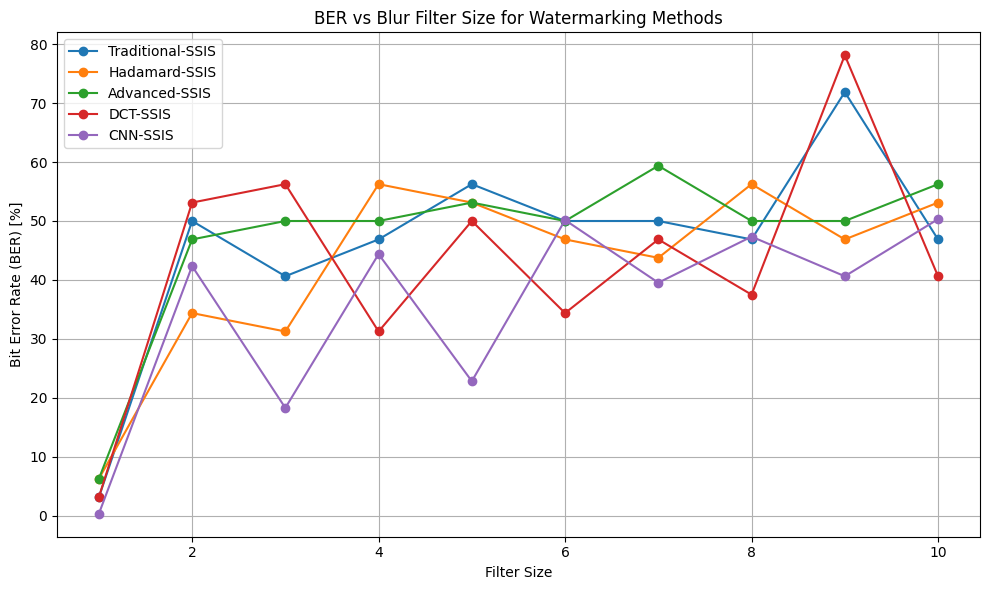

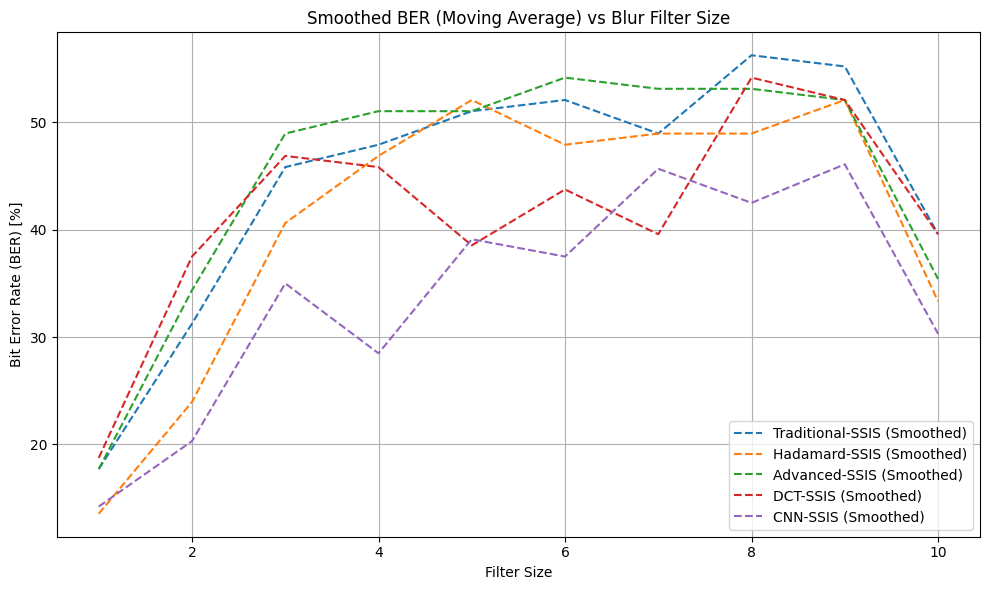

In [ ]:
# Parameters
iterations = 50
cnn_iterations = 20

filter_sizes = range(1, 11)  # Filter sizes from 1 to 10
ber_results = {
    "Traditional-SSIS": [],
    "Hadamard-SSIS": [],
    "Advanced-SSIS": [],
    "DCT-SSIS": [],
    "CNN-SSIS": []
}

# === SSIS METHODS (1: Traditional, 2: Hadamard, 3: Advanced, 4: DCT-SSIS) ===
for method_flag, method_name in zip([1, 2, 3, 4], list(ber_results.keys())[:4]):
    print(f"\nRunning experiment: {method_name}")

    for idx, filter_size in enumerate(filter_sizes):
        total_ber = 0

        for i in range(iterations):
            print(f"     Iteration {i+1}/{iterations}", end='\r')
            watermark_bits = np.random.choice([0, 1], size=32)

            index = np.random.randint(0, len(test_image_array))
            im = test_image_array[index]

            full_watermarked, pn_dict = complete_embedding(im, watermark_bits, method_flag)

            # Channel
            channel = Channel(full_watermarked)
            noisy_watermarked = channel.blur_image(filter_size)

            # Reconstruction based on method
            if method_flag == 4:
                reconstruction_bits = complete_dct_reconstruction(noisy_watermarked, pn_dict)
            else:
                reconstruction_bits = complete_reconstruction(noisy_watermarked, pn_dict)

            total_ber += calculate_ber(watermark_bits, reconstruction_bits)

        avg_ber = total_ber / iterations
        ber_results[method_name].append(avg_ber)
        print(f"→ Step {idx+1}/{len(filter_sizes)} | Filter Size = {filter_size} | Avg_BER = {avg_ber * 100:.2f}%")


# === CNN-BASED METHOD ===
print(f"\nRunning experiment: CNN-Based")
for idx, filter_size in enumerate(filter_sizes):
    total_ber = 0

    for i in range(cnn_iterations):
        print(f"     Iteration {i+1}/{cnn_iterations}", end='\r')
        watermark_bits = np.random.choice([0, 1], size=32)

        index = np.random.randint(0, len(test_image_array))
        im = test_image_array[index]

        full_watermarked = complete_CNN_embedding(im, watermark_bits, mask_ratio)

        # Channel
        channel = Channel(full_watermarked)
        noisy_watermarked = channel.blur_image(filter_size)

        reconstruction_bits = complete_CNN_reconstruction(noisy_watermarked, model)
        total_ber += calculate_ber(watermark_bits, reconstruction_bits)

    avg_ber = total_ber / cnn_iterations
    ber_results["CNN-SSIS"].append(avg_ber)
    print(f"→ Step {idx+1}/{len(filter_sizes)} | Filter Size = {filter_size} | Avg_BER = {avg_ber * 100:.2f}%")


# === ORIGINAL BER PLOT ===
plt.figure(figsize=(10, 6))
for method_name, ber_list in ber_results.items():
    plt.plot(filter_sizes, np.array(ber_list) * 100, label=method_name, marker='o')

plt.title("BER vs Blur Filter Size for Watermarking Methods")
plt.xlabel("Filter Size")
plt.ylabel("Bit Error Rate (BER) [%]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# === SMOOTHED BER PLOT ===
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

plt.figure(figsize=(10, 6))
window_size = 3
for method_name, ber_list in ber_results.items():
    smoothed = moving_average(np.array(ber_list) * 100, window_size)
    plt.plot(filter_sizes, smoothed, label=f"{method_name} (Smoothed)", linestyle='--')

plt.title("Smoothed BER (Moving Average) vs Blur Filter Size")
plt.xlabel("Filter Size")
plt.ylabel("Bit Error Rate (BER) [%]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


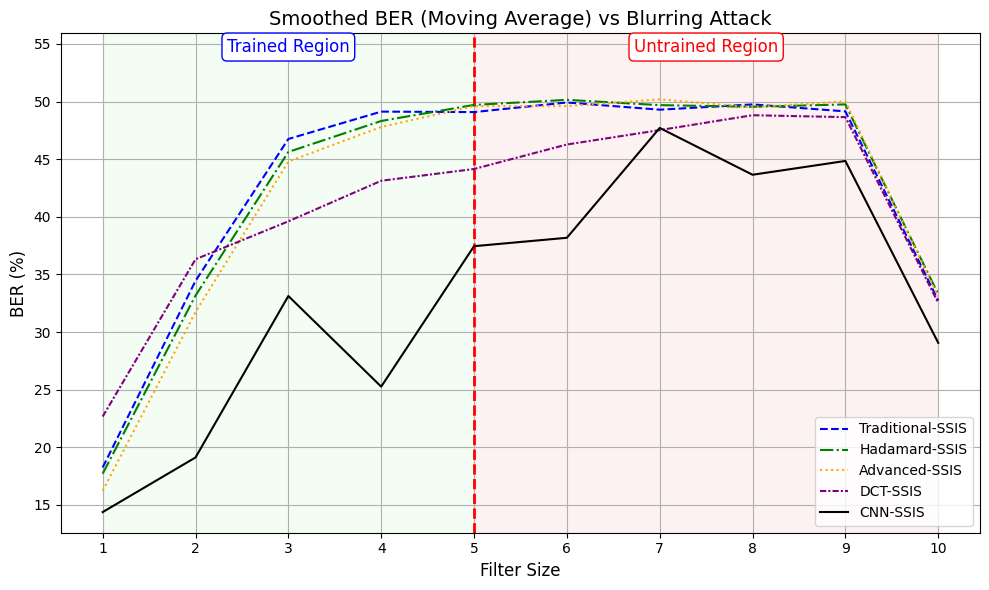

In [ ]:
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

plt.figure(figsize=(10, 6))
window_size = 3
cut = window_size // 2
line_styles = ['--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'green', 'orange', 'purple', 'teal']

# Background color regions
plt.axvspan(1, 5, color='lightgreen', alpha=0.1, label='_nolegend_')  # Trained
plt.axvspan(5, max(filter_sizes), color='lightcoral', alpha=0.1, label='_nolegend_')  # Untrained

# Vertical line at Filter Size = 5
plt.axvline(x=5, color='red', linestyle='--', linewidth=2)

# Plot all methods
for i, (method_name, ber_list) in enumerate(ber_results.items()):
    smoothed = moving_average(np.array(ber_list) * 100, window_size)

    if "cnn" in method_name.lower():
        linestyle = '-'
        color = 'black'
    else:
        linestyle = line_styles[i % len(line_styles)]
        color = colors[i % len(colors)]

    plt.plot(filter_sizes, smoothed, label=method_name, linestyle=linestyle, color=color)

# Force all integer ticks and make sure 5 is shown
plt.xticks(range(min(filter_sizes), max(filter_sizes) + 1, 1))  # Tick every integer filter size

# Get current y limits for label placement
ymin, ymax = plt.ylim()
xmid_left = (1 + 5) / 2
xmid_right = (5 + max(filter_sizes)) / 2
label_y = ymax + (ymax - ymin) * 0.05

# Region labels (above)
plt.text(xmid_left, label_y, "Trained Region", ha='center', va='bottom', fontsize=12, color='blue',
         bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.3'))
plt.text(xmid_right, label_y, "Untrained Region", ha='center', va='bottom', fontsize=12, color='red',
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))

# Extend y-limits to fit labels
plt.ylim(ymin, label_y + (ymax - ymin) * 0.05)

# Final touches
plt.title("Smoothed BER (Moving Average) vs Blurring Attack", fontsize=14)
plt.xlabel("Filter Size", fontsize=12)
plt.ylabel("BER (%)", fontsize=12)
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### JPEG Attack

In [ ]:
# Parameters
iterations = 2
cnn_iterations = 20

jpeg_qualities = range(50, 51)  # JPEG quality from 50 to 96
ber_results = {
    "Traditional-SSIS": [],
    "Hadamard-SSIS": [],
    "Advanced-SSIS": [],
    "DCT-SSIS": [],
    "CNN-SSIS": []
}

# === SSIS METHODS (1: Traditional, 2: Hadamard, 3: Advanced, 4: DCT-SSIS) ===
for method_flag, method_name in zip([1, 2, 3, 4], list(ber_results.keys())[:4]):
    print(f"\nRunning JPEG compression attack experiment: {method_name}")

    for idx, quality in enumerate(jpeg_qualities):
        total_ber = 0

        for i in range(iterations):
            print(f"     Iteration {i+1}/{iterations}", end='\r')
            watermark_bits = np.random.choice([0, 1], size=32)

            index = np.random.randint(0, len(test_image_array))
            im = test_image_array[index]

            full_watermarked, pn_dict = complete_embedding(im, watermark_bits, method_flag)

            # Channel
            channel = Channel(full_watermarked)
            noisy_watermarked = channel.jpeg_compress_grayscale_image(quality)

            # Reconstruction based on method
            if method_flag == 4:
                reconstruction_bits = complete_dct_reconstruction(noisy_watermarked, pn_dict)
            else:
                reconstruction_bits = complete_reconstruction(noisy_watermarked, pn_dict)

            total_ber += calculate_ber(watermark_bits, reconstruction_bits)

        avg_ber = total_ber / iterations
        ber_results[method_name].append(avg_ber)
        print(f"→ Step {idx+1}/{len(jpeg_qualities)} | JPEG Quality = {quality} | Avg_BER = {avg_ber * 100:.2f}%")


# === CNN-BASED METHOD ===
print(f"\nRunning JPEG compression attack experiment: CNN-Based")
for idx, quality in enumerate(jpeg_qualities):
    total_ber = 0

    for i in range(cnn_iterations):
        print(f"     Iteration {i+1}/{cnn_iterations}", end='\r')
        watermark_bits = np.random.choice([0, 1], size=32)

        index = np.random.randint(0, len(test_image_array))
        im = test_image_array[index]

        full_watermarked = complete_CNN_embedding(im, watermark_bits, mask_ratio)

        # Channel
        channel = Channel(full_watermarked)
        noisy_watermarked = channel.jpeg_compress_grayscale_image(quality)

        reconstruction_bits = complete_CNN_reconstruction(noisy_watermarked, model)
        total_ber += calculate_ber(watermark_bits, reconstruction_bits)

    avg_ber = total_ber / cnn_iterations
    ber_results["CNN-SSIS"].append(avg_ber)
    print(f"→ Step {idx+1}/{len(jpeg_qualities)} | JPEG Quality = {quality} | Avg_BER = {avg_ber * 100:.2f}%")


# # === BER PLOT ===
# plt.figure(figsize=(10, 6))
# for method_name, ber_list in ber_results.items():
#     plt.plot(jpeg_qualities, np.array(ber_list) * 100, label=method_name, marker='o')

# plt.title("BER vs JPEG Compression Quality for Watermarking Methods")
# plt.xlabel("JPEG Quality (Higher = Less Compression)")
# plt.ylabel("Bit Error Rate (BER) [%]")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


# # === SMOOTHED BER PLOT ===
# def moving_average(data, window_size=3):
#     return np.convolve(data, np.ones(window_size) / window_size, mode='same')

# plt.figure(figsize=(10, 6))
# window_size = 3
# for method_name, ber_list in ber_results.items():
#     smoothed = moving_average(np.array(ber_list) * 100, window_size)
#     plt.plot(jpeg_qualities, smoothed, label=f"{method_name} (Smoothed)", linestyle='--')

# plt.title("Smoothed BER (Moving Average) vs JPEG Compression Quality")
# plt.xlabel("JPEG Quality (Higher = Less Compression)")
# plt.ylabel("Bit Error Rate (BER) [%]")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()



Running JPEG compression attack experiment: Traditional-SSIS
→ Step 1/1 | JPEG Quality = 50 | Avg_BER = 20.31%

Running JPEG compression attack experiment: Hadamard-SSIS
→ Step 1/1 | JPEG Quality = 50 | Avg_BER = 25.00%

Running JPEG compression attack experiment: Advanced-SSIS
→ Step 1/1 | JPEG Quality = 50 | Avg_BER = 18.75%

Running JPEG compression attack experiment: DCT-SSIS
→ Step 1/1 | JPEG Quality = 50 | Avg_BER = 43.75%

Running JPEG compression attack experiment: CNN-Based
→ Step 1/1 | JPEG Quality = 50 | Avg_BER = 50.94%


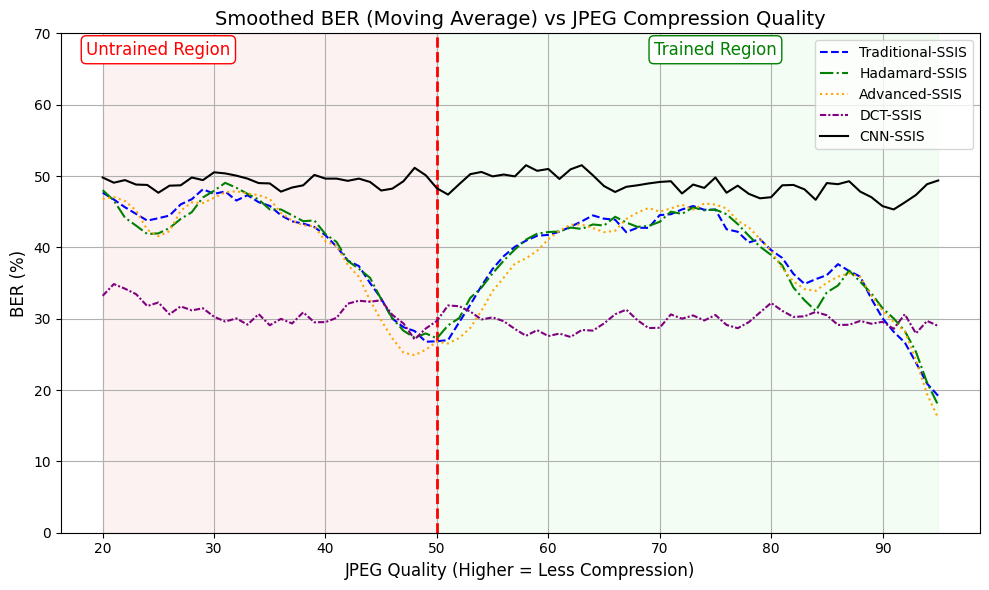

In [ ]:
# JPEG
from matplotlib.ticker import MaxNLocator

# === Enhanced Moving Average with edge padding ===
def moving_average(data, window_size=3):
    pad = window_size // 2
    padded = np.pad(data, (pad, pad), mode='edge')
    return np.convolve(padded, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(10, 6))
window_size = 3

# Custom styles
line_styles = ['--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'green', 'orange', 'purple', 'teal']

# Background regions: note quality range [0, 100]
plt.axvspan(min(jpeg_qualities), 50, color='lightcoral', alpha=0.1, label='_nolegend_')  # Untrained region
plt.axvspan(50, max(jpeg_qualities), color='lightgreen', alpha=0.1, label='_nolegend_')  # Trained region

# Vertical split line at JPEG quality = 50
plt.axvline(x=50, color='red', linestyle='--', linewidth=2)

# Plot smoothed BER curves
for i, (method_name, ber_list) in enumerate(ber_results.items()):
    smoothed = moving_average(np.array(ber_list) * 100, window_size)

    if "cnn" in method_name.lower():
        linestyle = '-'
        color = 'black'
    else:
        linestyle = line_styles[i % len(line_styles)]
        color = colors[i % len(colors)]

    plt.plot(jpeg_qualities, smoothed, label=method_name, linestyle=linestyle, color=color)

# Tick settings
plt.xticks(np.arange(min(jpeg_qualities), max(jpeg_qualities)+1, 10))
plt.yticks(np.arange(0, 71, 10))
plt.ylim(0, 70)

# Region labels
plt.text(25, 67, "Untrained Region", ha='center', fontsize=12, color='red',
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))
plt.text(75, 67, "Trained Region", ha='center', fontsize=12, color='green',
         bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

# Titles and labels
plt.title("Smoothed BER (Moving Average) vs JPEG Compression Quality", fontsize=14)
plt.xlabel("JPEG Quality (Higher = Less Compression)", fontsize=12)
plt.ylabel("BER (%)", fontsize=12)
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


### Brightness Attack

In [ ]:
# Parameters
iterations = 50
cnn_iterations = 40
brightness_values = np.linspace(0, 0.8, 40)  # 40 steps from -0.7 to 0.7

ber_results = {
    "Traditional-SSIS": [],
    "Hadamard-SSIS": [],
    "Advanced-SSIS": [],
    "DCT-SSIS": [],
    "CNN-SSIS": []
}

# === SSIS METHODS (1: Traditional, 2: Hadamard, 3: Advanced, 4: DCT-SSIS) ===
for method_flag, method_name in zip([1, 2, 3, 4], list(ber_results.keys())[:4]):
    print(f"\nRunning experiment: {method_name}")

    for b_idx, brightness_value in enumerate(brightness_values):
        total_ber = 0

        for i in range(iterations):
            print(f"     Iteration {i+1}/{iterations}", end='\r')
            watermark_bits = np.random.choice([0, 1], size=32)

            index = np.random.randint(0, len(test_image_array))
            im = test_image_array[index]

            full_watermarked, pn_dict = complete_embedding(im, watermark_bits, method_flag)

            # Apply brightness attack
            channel = Channel(full_watermarked)
            noisy_watermarked = channel.brightness_attack(brightness_value)

            # Reconstruction
            if method_flag == 4:
                reconstruction_bits = complete_dct_reconstruction(noisy_watermarked, pn_dict)
            else:
                reconstruction_bits = complete_reconstruction(noisy_watermarked, pn_dict)

            total_ber += calculate_ber(watermark_bits, reconstruction_bits)

        avg_ber = total_ber / iterations
        ber_results[method_name].append(avg_ber)
        print(f"→ Step {b_idx+1}/{len(brightness_values)} | Brightness = {brightness_value:.2f} | Avg_BER = {avg_ber * 100:.2f}%")


# === CNN-BASED METHOD ===
print(f"\nRunning experiment: CNN-Based")
for b_idx, brightness_value in enumerate(brightness_values):
    total_ber = 0

    for i in range(cnn_iterations):
        print(f"     Iteration {i+1}/{cnn_iterations}", end='\r')
        watermark_bits = np.random.choice([0, 1], size=32)

        index = np.random.randint(0, len(test_image_array))
        im = test_image_array[index]

        full_watermarked = complete_CNN_embedding(im, watermark_bits, mask_ratio)

        # Apply brightness attack
        channel = Channel(full_watermarked)
        noisy_watermarked = channel.brightness_attack(brightness_value)

        # Reconstruction
        reconstruction_bits = complete_CNN_reconstruction(noisy_watermarked, model)
        total_ber += calculate_ber(watermark_bits, reconstruction_bits)

    avg_ber = total_ber / cnn_iterations
    ber_results["CNN-SSIS"].append(avg_ber)
    print(f"→ Step {b_idx+1}/{len(brightness_values)} | Brightness = {brightness_value:.2f} | Avg_BER = {avg_ber * 100:.2f}%")


# === BER PLOT ===
plt.figure(figsize=(10, 6))
x_axis = brightness_values
for method_name, ber_list in ber_results.items():
    plt.plot(x_axis, np.array(ber_list) * 100, label=method_name, marker='o')

plt.title("BER vs Brightness Attack for Watermarking Methods")
plt.xlabel("Brightness Value (Attack Strength)")
plt.ylabel("Bit Error Rate (BER) [%]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# === SMOOTHED BER PLOT ===
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

plt.figure(figsize=(10, 6))
for method_name, ber_list in ber_results.items():
    smoothed = moving_average(np.array(ber_list) * 100, window_size=3)
    plt.plot(x_axis, smoothed, label=f"{method_name} (Smoothed)", linestyle='--')

plt.title("Smoothed BER vs Brightness Attack")
plt.xlabel("Brightness Value")
plt.ylabel("Bit Error Rate (BER) [%]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Running experiment: Traditional-SSIS
→ Step 1/40 | Brightness = 0.00 | Avg_BER = 9.38%
→ Step 2/40 | Brightness = 0.02 | Avg_BER = 9.38%
→ Step 3/40 | Brightness = 0.04 | Avg_BER = 15.62%
→ Step 4/40 | Brightness = 0.06 | Avg_BER = 21.88%
→ Step 5/40 | Brightness = 0.08 | Avg_BER = 15.62%
→ Step 6/40 | Brightness = 0.10 | Avg_BER = 12.50%
→ Step 7/40 | Brightness = 0.12 | Avg_BER = 25.00%
→ Step 8/40 | Brightness = 0.14 | Avg_BER = 31.25%
→ Step 9/40 | Brightness = 0.16 | Avg_BER = 12.50%
→ Step 10/40 | Brightness = 0.18 | Avg_BER = 50.00%
→ Step 11/40 | Brightness = 0.21 | Avg_BER = 18.75%
→ Step 12/40 | Brightness = 0.23 | Avg_BER = 18.75%
→ Step 13/40 | Brightness = 0.25 | Avg_BER = 9.38%
→ Step 14/40 | Brightness = 0.27 | Avg_BER = 15.62%
→ Step 15/40 | Brightness = 0.29 | Avg_BER = 34.38%
→ Step 16/40 | Brightness = 0.31 | Avg_BER = 21.88%
→ Step 17/40 | Brightness = 0.33 | Avg_BER = 12.50%
→ Step 18/40 | Brightness = 0.35 | Avg_BER = 43.75%
→ Step 19/40 | Brightness = 0.37 | Avg

KeyboardInterrupt: 

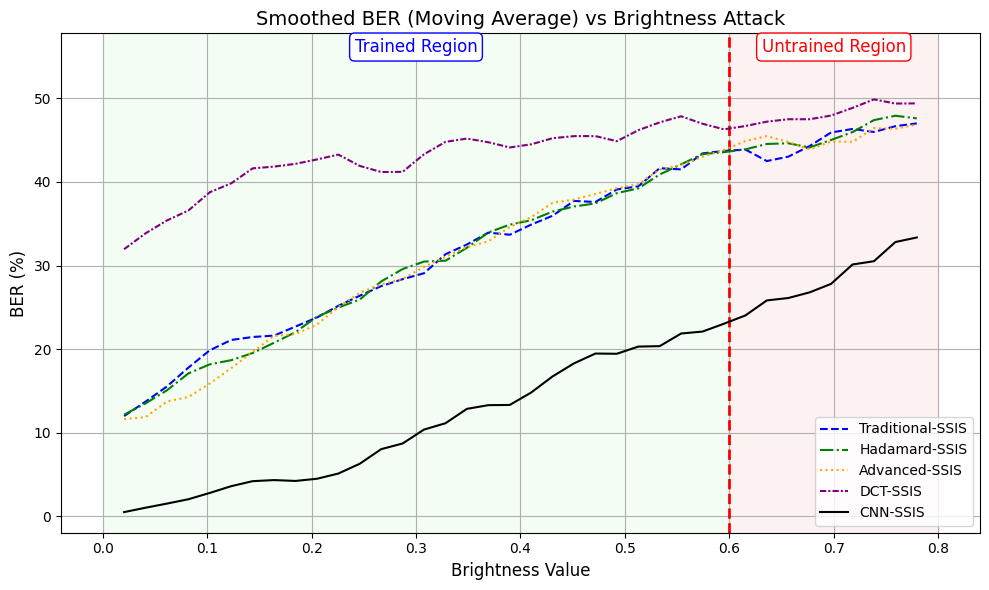

In [ ]:
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

plt.figure(figsize=(10, 6))
window_size = 3
cut = window_size // 2
line_styles = ['--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'green', 'orange', 'purple', 'teal']

trained_threshold = 0.6

# Background color regions
plt.axvspan(min(brightness_values), trained_threshold, color='lightgreen', alpha=0.1, label='_nolegend_')  # Trained
plt.axvspan(trained_threshold, max(brightness_values), color='lightcoral', alpha=0.1, label='_nolegend_')  # Untrained

# Vertical line at threshold
plt.axvline(x=trained_threshold, color='red', linestyle='--', linewidth=2)

# Plot all methods
for i, (method_name, ber_list) in enumerate(ber_results.items()):
    raw = np.array(ber_list) * 100
    smoothed = moving_average(raw, window_size)

    # Trim edges to avoid edge effect
    x_trimmed = brightness_values[cut:-cut] if cut > 0 else brightness_values
    smoothed_trimmed = smoothed[cut:-cut] if cut > 0 else smoothed

    if "cnn" in method_name.lower():
        linestyle = '-'
        color = 'black'
    else:
        linestyle = line_styles[i % len(line_styles)]
        color = colors[i % len(colors)]

    plt.plot(x_trimmed, smoothed_trimmed, label=method_name, linestyle=linestyle, color=color)

# Get y-limits
ymin, ymax = plt.ylim()
xmid_left = (min(brightness_values) + trained_threshold) / 2
xmid_right = (trained_threshold + max(brightness_values)) / 2
label_y = ymax + (ymax - ymin) * 0.05

# Region labels
plt.text(xmid_left, label_y, "Trained Region", ha='center', va='bottom', fontsize=12, color='blue',
         bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.3'))
plt.text(xmid_right, label_y, "Untrained Region", ha='center', va='bottom', fontsize=12, color='red',
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))

# Adjust y-limit
plt.ylim(ymin, label_y + (ymax - ymin) * 0.05)

# Final touches
plt.title("Smoothed BER (Moving Average) vs Brightness Attack", fontsize=14)
plt.xlabel("Brightness Value", fontsize=12)
plt.ylabel("BER (%)", fontsize=12)
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


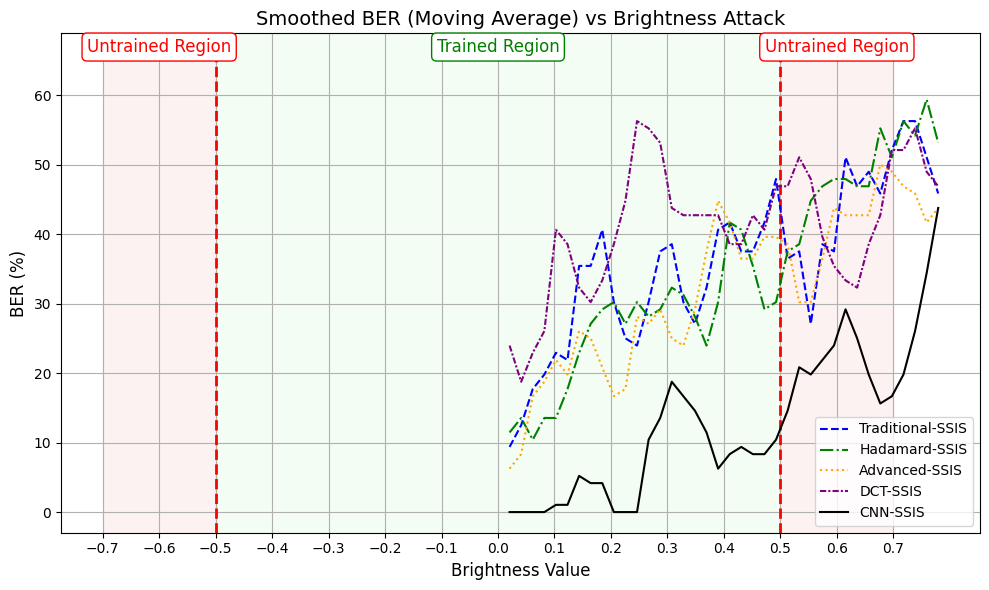

In [ ]:
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

plt.figure(figsize=(10, 6))
window_size = 3
cut = window_size // 2
line_styles = ['--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'green', 'orange', 'purple', 'teal']

# Background shaded regions
plt.axvspan(-0.7, -0.5, color='lightcoral', alpha=0.1, label='_nolegend_')  # Untrained (Left)
plt.axvspan(-0.5, 0.5, color='lightgreen', alpha=0.1, label='_nolegend_')   # Trained
plt.axvspan(0.5, 0.7, color='lightcoral', alpha=0.1, label='_nolegend_')    # Untrained (Right)

# Vertical red dashed lines at ±0.5
plt.axvline(x=-0.5, color='red', linestyle='--', linewidth=2)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2)

# Plot each method
for i, (method_name, ber_list) in enumerate(ber_results.items()):
    smoothed = moving_average(np.array(ber_list) * 100, window_size)
    x_vals = brightness_values[cut: -cut]
    y_vals = smoothed[cut: -cut]

    if "cnn" in method_name.lower():
        linestyle = '-'
        color = 'black'
    else:
        linestyle = line_styles[i % len(line_styles)]
        color = colors[i % len(colors)]

    plt.plot(x_vals, y_vals, label=method_name, linestyle=linestyle, color=color)

# Set cleaner x-axis ticks at 0.1 intervals
plt.xticks(np.round(np.arange(-0.7, 0.71, 0.1), 2))

# Add region labels
ymin, ymax = plt.ylim()
label_y = ymax + (ymax - ymin) * 0.05

plt.text(-0.6, label_y, "Untrained Region", ha='center', va='bottom', fontsize=12, color='red',
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))
plt.text(0.0, label_y, "Trained Region", ha='center', va='bottom', fontsize=12, color='green',
         bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))
plt.text(0.6, label_y, "Untrained Region", ha='center', va='bottom', fontsize=12, color='red',
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))

# Adjust y-limit to fit region labels
plt.ylim(ymin, label_y + (ymax - ymin) * 0.05)

# Final polish
plt.title("Smoothed BER (Moving Average) vs Brightness Attack", fontsize=14)
plt.xlabel("Brightness Value", fontsize=12)
plt.ylabel("BER (%)", fontsize=12)
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### Contrast Attack


Running contrast experiment: Traditional-SSIS
→ Step 1/40 | Contrast = 0.00 | Avg_BER = 43.75%
→ Step 2/40 | Contrast = 0.05 | Avg_BER = 59.38%
→ Step 3/40 | Contrast = 0.10 | Avg_BER = 56.25%
→ Step 4/40 | Contrast = 0.15 | Avg_BER = 56.25%
→ Step 5/40 | Contrast = 0.21 | Avg_BER = 37.50%
→ Step 6/40 | Contrast = 0.26 | Avg_BER = 56.25%
→ Step 7/40 | Contrast = 0.31 | Avg_BER = 40.62%
→ Step 8/40 | Contrast = 0.36 | Avg_BER = 46.88%
→ Step 9/40 | Contrast = 0.41 | Avg_BER = 37.50%
→ Step 10/40 | Contrast = 0.46 | Avg_BER = 25.00%
→ Step 11/40 | Contrast = 0.51 | Avg_BER = 31.25%
→ Step 12/40 | Contrast = 0.56 | Avg_BER = 37.50%
→ Step 13/40 | Contrast = 0.62 | Avg_BER = 28.12%
→ Step 14/40 | Contrast = 0.67 | Avg_BER = 18.75%
→ Step 15/40 | Contrast = 0.72 | Avg_BER = 43.75%
→ Step 16/40 | Contrast = 0.77 | Avg_BER = 18.75%
→ Step 17/40 | Contrast = 0.82 | Avg_BER = 18.75%
→ Step 18/40 | Contrast = 0.87 | Avg_BER = 6.25%
→ Step 19/40 | Contrast = 0.92 | Avg_BER = 9.38%
→ Step 20/40 |

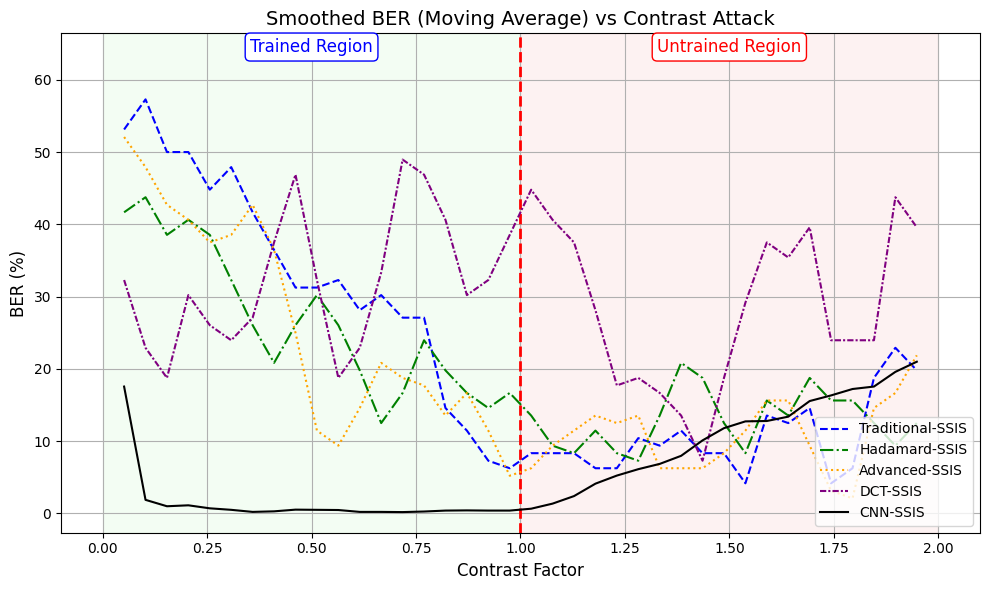

In [ ]:
# === PARAMETERS ===
iterations = 50
cnn_iterations = 40
contrast_values = np.linspace(0, 2, 40)  # 40 steps from 0 to 2.5
trained_threshold = 1  # Threshold between trained and untrained region

ber_results_contrast = {
    "Traditional-SSIS": [],
    "Hadamard-SSIS": [],
    "Advanced-SSIS": [],
    "DCT-SSIS": [],
    "CNN-SSIS": []
}

# === SSIS METHODS ===
for method_flag, method_name in zip([1, 2, 3, 4], list(ber_results_contrast.keys())[:4]):
    print(f"\nRunning contrast experiment: {method_name}")

    for c_idx, contrast_value in enumerate(contrast_values):
        total_ber = 0

        for i in range(iterations):
            print(f"     Iteration {i+1}/{iterations}", end='\r')
            watermark_bits = np.random.choice([0, 1], size=32)

            index = np.random.randint(0, len(test_image_array))
            im = test_image_array[index]

            full_watermarked, pn_dict = complete_embedding(im, watermark_bits, method_flag)

            # Apply contrast attack
            channel = Channel(full_watermarked)
            noisy_watermarked = channel.contrast_attack(contrast_value)

            # Reconstruction
            if method_flag == 4:
                reconstruction_bits = complete_dct_reconstruction(noisy_watermarked, pn_dict)
            else:
                reconstruction_bits = complete_reconstruction(noisy_watermarked, pn_dict)

            total_ber += calculate_ber(watermark_bits, reconstruction_bits)

        avg_ber = total_ber / iterations
        ber_results_contrast[method_name].append(avg_ber)
        print(f"→ Step {c_idx+1}/{len(contrast_values)} | Contrast = {contrast_value:.2f} | Avg_BER = {avg_ber * 100:.2f}%")

# === CNN-BASED METHOD ===
print(f"\nRunning contrast experiment: CNN-Based")

for c_idx, contrast_value in enumerate(contrast_values):
    total_ber = 0

    for i in range(cnn_iterations):
        print(f"     Iteration {i+1}/{cnn_iterations}", end='\r')
        watermark_bits = np.random.choice([0, 1], size=32)

        index = np.random.randint(0, len(test_image_array))
        im = test_image_array[index]

        full_watermarked = complete_CNN_embedding(im, watermark_bits, mask_ratio)

        # Apply contrast attack
        channel = Channel(full_watermarked)
        noisy_watermarked = channel.contrast_attack(contrast_value)

        reconstruction_bits = complete_CNN_reconstruction(noisy_watermarked, model)
        total_ber += calculate_ber(watermark_bits, reconstruction_bits)

    avg_ber = total_ber / cnn_iterations
    ber_results_contrast["CNN-SSIS"].append(avg_ber)
    print(f"→ Step {c_idx+1}/{len(contrast_values)} | Contrast = {contrast_value:.2f} | Avg_BER = {avg_ber * 100:.2f}%")

# === PLOT: SMOOTHED BER WITH REGION SEPARATION ===
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

plt.figure(figsize=(10, 6))
window_size = 3
cut = window_size // 2
line_styles = ['--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'green', 'orange', 'purple', 'teal']

# Background color regions
plt.axvspan(min(contrast_values), trained_threshold, color='lightgreen', alpha=0.1, label='_nolegend_')  # Trained
plt.axvspan(trained_threshold, max(contrast_values), color='lightcoral', alpha=0.1, label='_nolegend_')  # Untrained

# Vertical dashed line at contrast = trained_threshold
plt.axvline(x=trained_threshold, color='red', linestyle='--', linewidth=2)

# Plot each method
for i, (method_name, ber_list) in enumerate(ber_results_contrast.items()):
    raw = np.array(ber_list) * 100
    smoothed = moving_average(raw, window_size)

    # Trim edges to avoid moving average distortion
    x_trimmed = contrast_values[cut:-cut] if cut > 0 else contrast_values
    smoothed_trimmed = smoothed[cut:-cut] if cut > 0 else smoothed

    if "cnn" in method_name.lower():
        linestyle = '-'
        color = 'black'
    else:
        linestyle = line_styles[i % len(line_styles)]
        color = colors[i % len(colors)]

    plt.plot(x_trimmed, smoothed_trimmed, label=method_name, linestyle=linestyle, color=color)

# Label regions
ymin, ymax = plt.ylim()
xmid_left = (min(contrast_values) + trained_threshold) / 2
xmid_right = (trained_threshold + max(contrast_values)) / 2
label_y = ymax + (ymax - ymin) * 0.05

plt.text(xmid_left, label_y, "Trained Region", ha='center', va='bottom', fontsize=12, color='blue',
         bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.3'))
plt.text(xmid_right, label_y, "Untrained Region", ha='center', va='bottom', fontsize=12, color='red',
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))

plt.ylim(ymin, label_y + (ymax - ymin) * 0.05)

plt.title("Smoothed BER (Moving Average) vs Contrast Attack", fontsize=14)
plt.xlabel("Contrast Factor", fontsize=12)
plt.ylabel("BER (%)", fontsize=12)
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


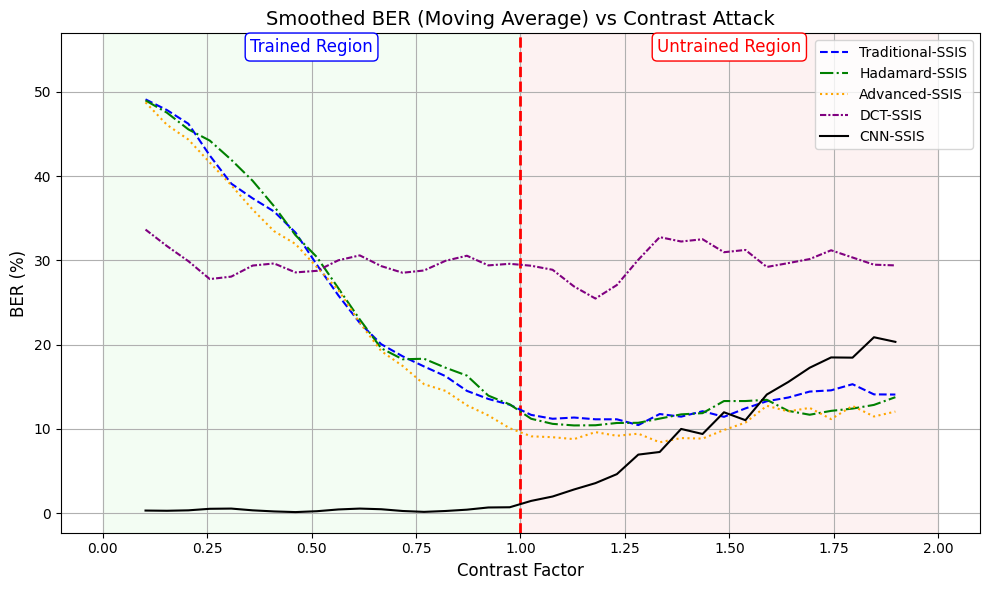

In [ ]:
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

plt.figure(figsize=(10, 6))
window_size = 3
cut = 2  # افزایش مقدار cut برای حذف نمونه‌های ابتدایی بیشتر
line_styles = ['--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'green', 'orange', 'purple', 'teal']

# Background color regions
plt.axvspan(min(contrast_values), trained_threshold, color='lightgreen', alpha=0.1, label='_nolegend_')  # Trained
plt.axvspan(trained_threshold, max(contrast_values), color='lightcoral', alpha=0.1, label='_nolegend_')  # Untrained

# Vertical dashed line at contrast = trained_threshold
plt.axvline(x=trained_threshold, color='red', linestyle='--', linewidth=2)

for i, (method_name, ber_list) in enumerate(ber_results_contrast.items()):
    raw = np.array(ber_list) * 100
    smoothed = moving_average(raw, window_size)

    # Trim edges more aggressively to avoid moving average distortion at start
    x_trimmed = contrast_values[cut:-cut] if cut > 0 else contrast_values
    smoothed_trimmed = smoothed[cut:-cut] if cut > 0 else smoothed

    if "cnn" in method_name.lower():
        linestyle = '-'
        color = 'black'
    else:
        linestyle = line_styles[i % len(line_styles)]
        color = colors[i % len(colors)]

    plt.plot(x_trimmed, smoothed_trimmed, label=method_name, linestyle=linestyle, color=color)

# Label regions
ymin, ymax = plt.ylim()
xmid_left = (min(contrast_values) + trained_threshold) / 2
xmid_right = (trained_threshold + max(contrast_values)) / 2
label_y = ymax + (ymax - ymin) * 0.05

plt.text(xmid_left, label_y, "Trained Region", ha='center', va='bottom', fontsize=12, color='blue',
         bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.3'))
plt.text(xmid_right, label_y, "Untrained Region", ha='center', va='bottom', fontsize=12, color='red',
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))

plt.ylim(ymin, label_y + (ymax - ymin) * 0.05)

plt.title("Smoothed BER (Moving Average) vs Contrast Attack", fontsize=14)
plt.xlabel("Contrast Factor", fontsize=12)
plt.ylabel("BER (%)", fontsize=12)
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


## Geometric

### Shift Attack

In [ ]:
# Parameters
iterations = 50
cnn_iterations = 20

shift_amounts = range(1, 128)  # Shift from 1 to 8 pixels
ber_results = {
    "Traditional-SSIS": [],
    "Hadamard-SSIS": [],
    "Advanced-SSIS": [],
    "DCT-SSIS": [],
    "CNN-SSIS": []
}

# === SSIS METHODS (1: Traditional, 2: Hadamard, 3: Advanced, 4: DCT-SSIS) ===
for method_flag, method_name in zip([1, 2, 3, 4], list(ber_results.keys())[:4]):
    print(f"\nRunning experiment: {method_name}")

    for idx, shift_val in enumerate(shift_amounts):
        total_ber = 0

        for i in range(iterations):
            print(f"     Iteration {i+1}/{iterations}", end='\r')
            watermark_bits = np.random.choice([0, 1], size=32)

            index = np.random.randint(0, len(test_image_array))
            im = test_image_array[index]

            full_watermarked, pn_dict = complete_embedding(im, watermark_bits, method_flag)

            # Apply X-shift attack
            channel = Channel(full_watermarked)
            noisy_watermarked = channel.x_shift_attack(shift_val)

            # Reconstruction
            if method_flag == 4:
                reconstruction_bits = complete_dct_reconstruction(noisy_watermarked, pn_dict)
            else:
                reconstruction_bits = complete_reconstruction(noisy_watermarked, pn_dict)

            total_ber += calculate_ber(watermark_bits, reconstruction_bits)

        avg_ber = total_ber / iterations
        ber_results[method_name].append(avg_ber)
        print(f"→ Step {idx+1}/{len(shift_amounts)} | Shift = {shift_val } px | Avg_BER = {avg_ber * 100:.2f}%")


# === CNN-BASED METHOD ===
print(f"\nRunning experiment: CNN-Based")
for idx, shift_val  in enumerate(shift_amounts):
    total_ber = 0

    for i in range(cnn_iterations):
        print(f"     Iteration {i+1}/{cnn_iterations}", end='\r')
        watermark_bits = np.random.choice([0, 1], size=32)

        index = np.random.randint(0, len(test_image_array))
        im = test_image_array[index]

        full_watermarked = complete_CNN_embedding(im, watermark_bits, mask_ratio)

        # Apply X-shift attack
        channel = Channel(full_watermarked)
        noisy_watermarked = channel.x_shift_attack(shift_val )

        reconstruction_bits = complete_CNN_reconstruction(noisy_watermarked, model)
        total_ber += calculate_ber(watermark_bits, reconstruction_bits)

    avg_ber = total_ber / cnn_iterations
    ber_results["CNN-SSIS"].append(avg_ber)
    print(f"→ Step {idx+1}/{len(shift_amounts)} | Shift = {shift_val } px | Avg_BER = {avg_ber * 100:.2f}%")


# === ORIGINAL BER PLOT ===
plt.figure(figsize=(10, 6))
for method_name, ber_list in ber_results.items():
    plt.plot(shift_amounts, np.array(ber_list) * 100, label=method_name, marker='o')

plt.title("BER vs X-Shift Amount for Watermarking Methods")
plt.xlabel("Shift Amount (pixels)")
plt.ylabel("Bit Error Rate (BER) [%]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# === SMOOTHED BER PLOT ===
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

plt.figure(figsize=(10, 6))
window_size = 3
for method_name, ber_list in ber_results.items():
    smoothed = moving_average(np.array(ber_list) * 100, window_size)
    plt.plot(shift_amounts, smoothed, label=f"{method_name} (Smoothed)", linestyle='--')

plt.title("Smoothed BER (Moving Average) vs X-Shift Amount")
plt.xlabel("Shift Amount (pixels)")
plt.ylabel("Bit Error Rate (BER) [%]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Running experiment: Traditional-SSIS
→ Step 1/127 | Shift = 1 px | Avg_BER = 46.88%
→ Step 2/127 | Shift = 2 px | Avg_BER = 46.88%
→ Step 3/127 | Shift = 3 px | Avg_BER = 34.38%
→ Step 4/127 | Shift = 4 px | Avg_BER = 56.25%
→ Step 5/127 | Shift = 5 px | Avg_BER = 43.75%
→ Step 6/127 | Shift = 6 px | Avg_BER = 65.62%
→ Step 7/127 | Shift = 7 px | Avg_BER = 50.00%
→ Step 8/127 | Shift = 8 px | Avg_BER = 37.50%
→ Step 9/127 | Shift = 9 px | Avg_BER = 62.50%
→ Step 10/127 | Shift = 10 px | Avg_BER = 59.38%
→ Step 11/127 | Shift = 11 px | Avg_BER = 43.75%
→ Step 12/127 | Shift = 12 px | Avg_BER = 53.12%
→ Step 13/127 | Shift = 13 px | Avg_BER = 53.12%
→ Step 14/127 | Shift = 14 px | Avg_BER = 43.75%
→ Step 15/127 | Shift = 15 px | Avg_BER = 62.50%
→ Step 16/127 | Shift = 16 px | Avg_BER = 56.25%
→ Step 17/127 | Shift = 17 px | Avg_BER = 62.50%
→ Step 18/127 | Shift = 18 px | Avg_BER = 56.25%
→ Step 19/127 | Shift = 19 px | Avg_BER = 53.12%
→ Step 20/127 | Shift = 20 px | Avg_BER = 50.00%


KeyboardInterrupt: 

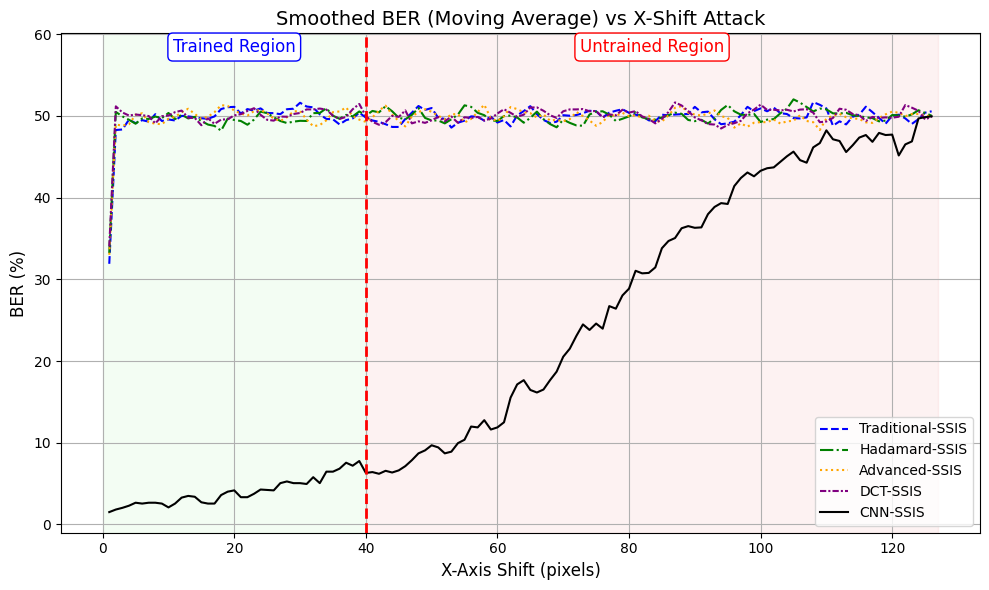

In [ ]:

def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

plt.figure(figsize=(10, 6))
window_size = 3
cut = window_size // 2  # number of points to cut from end to avoid artificial drop

# Define line styles and colors
line_styles = ['--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'green', 'orange', 'purple', 'teal']

# Plot each method
for i, (method_name, ber_list) in enumerate(ber_results.items()):
    smoothed = moving_average(np.array(ber_list) * 100, window_size)

    # Set solid line for CNN-based method
    if "cnn" in method_name.lower():
        linestyle = '-'  # solid
        color = 'black'  # standout color for CNN
    else:
        linestyle = line_styles[i % len(line_styles)]
        color = colors[i % len(colors)]

    plt.plot(shift_amounts[:-cut], smoothed[:-cut], label=method_name, linestyle=linestyle, color=color)

# Add very light background shaded regions
plt.axvspan(0, 40, color='lightgreen', alpha=0.1, label='_nolegend_')       # Trained Region
plt.axvspan(40, max(shift_amounts), color='lightcoral', alpha=0.1, label='_nolegend_')  # Untrained Region

# Add dashed red vertical line at shift=40
plt.axvline(x=40, color='red', linestyle='--', linewidth=2)

# Adjust region labels ABOVE the plot
ymin, ymax = plt.ylim()
xmid_left = (0 + 40) / 2
xmid_right = (40 + max(shift_amounts)) / 2
label_y = ymax + (ymax - ymin) * 0.05  # move labels above curves

plt.text(xmid_left, label_y, "Trained Region", ha='center', va='bottom', fontsize=12, color='blue',
         bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.3'))

plt.text(xmid_right, label_y, "Untrained Region", ha='center', va='bottom', fontsize=12, color='red',
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))

# Extend ylim to fit labels
plt.ylim(ymin, label_y + (ymax - ymin) * 0.05)

plt.title("Smoothed BER (Moving Average) vs X-Shift Attack", fontsize=14)
plt.xlabel("X-Axis Shift (pixels)", fontsize=12 )
plt.ylabel("BER (%)", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Rotation Attack

In [ ]:
# Parameters
iterations = 50
cnn_iterations = 20

rotation_angles = range(0, 23, 1)  # Rotation angles from -10 to 10 degrees in steps of 2
ber_results = {
    "Traditional-SSIS": [],
    "Hadamard-SSIS": [],
    "Advanced-SSIS": [],
    "DCT-SSIS": [],
    "CNN-SSIS": []
}

# === SSIS METHODS (1: Traditional, 2: Hadamard, 3: Advanced, 4: DCT-SSIS) ===
for method_flag, method_name in zip([1, 2, 3, 4], list(ber_results.keys())[:4]):
    print(f"\nRunning rotation attack experiment: {method_name}")

    for idx, angle in enumerate(rotation_angles):
        total_ber = 0

        for i in range(iterations):
            print(f"     Iteration {i+1}/{iterations}", end='\r')
            watermark_bits = np.random.choice([0, 1], size=32)

            index = np.random.randint(0, len(test_image_array))
            im = test_image_array[index]

            full_watermarked, pn_dict = complete_embedding(im, watermark_bits, method_flag)

            # Channel
            channel = Channel(full_watermarked)
            noisy_watermarked = channel.rotation_attack(angle)

            # Reconstruction based on method
            if method_flag == 4:
                reconstruction_bits = complete_dct_reconstruction(noisy_watermarked, pn_dict)
            else:
                reconstruction_bits = complete_reconstruction(noisy_watermarked, pn_dict)

            total_ber += calculate_ber(watermark_bits, reconstruction_bits)

        avg_ber = total_ber / iterations
        ber_results[method_name].append(avg_ber)
        print(f"→ Step {idx+1}/{len(rotation_angles)} | Angle = {angle} | Avg_BER = {avg_ber * 100:.2f}%")


# === CNN-BASED METHOD ===
print(f"\nRunning rotation attack experiment: CNN-Based")
for idx, angle in enumerate(rotation_angles):
    total_ber = 0

    for i in range(cnn_iterations):
        print(f"     Iteration {i+1}/{cnn_iterations}", end='\r')
        watermark_bits = np.random.choice([0, 1], size=32)

        index = np.random.randint(0, len(test_image_array))
        im = test_image_array[index]

        full_watermarked = complete_CNN_embedding(im, watermark_bits, mask_ratio)

        # Channel
        channel = Channel(full_watermarked)
        noisy_watermarked = channel.rotation_attack(angle)

        reconstruction_bits = complete_CNN_reconstruction(noisy_watermarked, model)
        total_ber += calculate_ber(watermark_bits, reconstruction_bits)

    avg_ber = total_ber / cnn_iterations
    ber_results["CNN-SSIS"].append(avg_ber)
    print(f"→ Step {idx+1}/{len(rotation_angles)} | Angle = {angle} | Avg_BER = {avg_ber * 100:.2f}%")


# === BER PLOT ===
plt.figure(figsize=(10, 6))
for method_name, ber_list in ber_results.items():
    plt.plot(rotation_angles, np.array(ber_list) * 100, label=method_name, marker='o')

plt.title("BER vs Rotation Angle for Watermarking Methods")
plt.xlabel("Rotation Angle (degrees)")
plt.ylabel("Bit Error Rate (BER) [%]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# === SMOOTHED BER PLOT ===
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

plt.figure(figsize=(10, 6))
window_size = 3
for method_name, ber_list in ber_results.items():
    smoothed = moving_average(np.array(ber_list) * 100, window_size)
    plt.plot(rotation_angles, smoothed, label=f"{method_name} (Smoothed)", linestyle='--')

plt.title("Smoothed BER (Moving Average) vs Rotation Angle")
plt.xlabel("Rotation Angle (degrees)")
plt.ylabel("Bit Error Rate (BER) [%]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Running rotation attack experiment: Traditional-SSIS
→ Step 1/23 | Angle = 0 | Avg_BER = 18.75%
→ Step 2/23 | Angle = 1 | Avg_BER = 31.25%
→ Step 3/23 | Angle = 2 | Avg_BER = 46.88%
→ Step 4/23 | Angle = 3 | Avg_BER = 62.50%
→ Step 5/23 | Angle = 4 | Avg_BER = 53.12%
→ Step 6/23 | Angle = 5 | Avg_BER = 43.75%
→ Step 7/23 | Angle = 6 | Avg_BER = 34.38%
→ Step 8/23 | Angle = 7 | Avg_BER = 46.88%
→ Step 9/23 | Angle = 8 | Avg_BER = 40.62%
→ Step 10/23 | Angle = 9 | Avg_BER = 50.00%
→ Step 11/23 | Angle = 10 | Avg_BER = 40.62%
→ Step 12/23 | Angle = 11 | Avg_BER = 59.38%
→ Step 13/23 | Angle = 12 | Avg_BER = 50.00%
→ Step 14/23 | Angle = 13 | Avg_BER = 53.12%
→ Step 15/23 | Angle = 14 | Avg_BER = 53.12%
→ Step 16/23 | Angle = 15 | Avg_BER = 40.62%
→ Step 17/23 | Angle = 16 | Avg_BER = 46.88%
→ Step 18/23 | Angle = 17 | Avg_BER = 43.75%
→ Step 19/23 | Angle = 18 | Avg_BER = 46.88%
→ Step 20/23 | Angle = 19 | Avg_BER = 50.00%
→ Step 21/23 | Angle = 20 | Avg_BER = 43.75%
→ Step 22/23 | Angle

KeyboardInterrupt: 

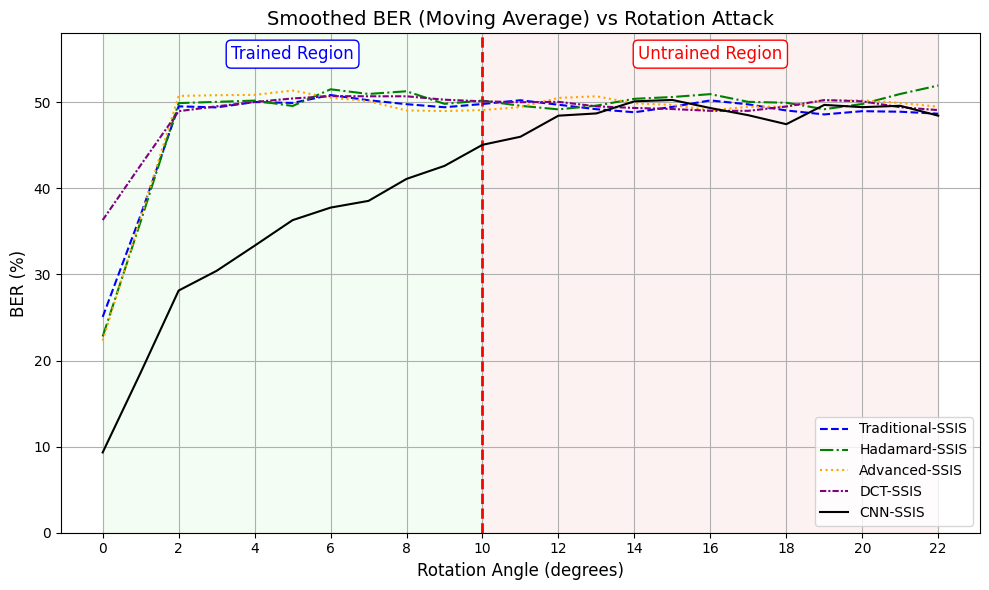

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# === Enhanced Moving Average with edge padding ===
def moving_average(data, window_size=3):
    pad = window_size // 2
    padded = np.pad(data, (pad, pad), mode='edge')
    return np.convolve(padded, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(10, 6))
window_size = 3

# Custom styles
line_styles = ['--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'green', 'orange', 'purple', 'teal']

# Background regions
plt.axvspan(min(rotation_angles), 10, color='lightgreen', alpha=0.1, label='_nolegend_')   # Trained
plt.axvspan(10, max(rotation_angles), color='lightcoral', alpha=0.1, label='_nolegend_')   # Untrained

# Vertical separation line
plt.axvline(x=10, color='red', linestyle='--', linewidth=2)

# Plot smoothed curves
for i, (method_name, ber_list) in enumerate(ber_results.items()):
    smoothed = moving_average(np.array(ber_list) * 100, window_size)

    if "cnn" in method_name.lower():
        linestyle = '-'
        color = 'black'
    else:
        linestyle = line_styles[i % len(line_styles)]
        color = colors[i % len(colors)]

    plt.plot(rotation_angles, smoothed, label=method_name, linestyle=linestyle, color=color)

# Set ticks
plt.xticks(np.arange(min(rotation_angles), max(rotation_angles)+1, 2))
plt.yticks(np.arange(0, 61, 10))  # 0 to 60 with step 10

# Set fixed Y-axis range
plt.ylim(0, 58)

# Region labels
plt.text(5, 55, "Trained Region", ha='center', fontsize=12, color='blue',
         bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.3'))
plt.text((10 + max(rotation_angles)) / 2, 55, "Untrained Region", ha='center', fontsize=12, color='red',
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))

# Axis titles and formatting
plt.title("Smoothed BER (Moving Average) vs Rotation Attack", fontsize=14)
plt.xlabel("Rotation Angle (degrees)", fontsize=12)
plt.ylabel("BER (%)", fontsize=12)
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### Crop Attack


Running crop attack experiment: Traditional-SSIS
→ Step 1/100 | Crop Fraction = 0.20 | Avg_BER = 48.88%
→ Step 2/100 | Crop Fraction = 0.21 | Avg_BER = 50.06%
→ Step 3/100 | Crop Fraction = 0.22 | Avg_BER = 49.38%
→ Step 4/100 | Crop Fraction = 0.22 | Avg_BER = 49.50%
→ Step 5/100 | Crop Fraction = 0.23 | Avg_BER = 48.94%
→ Step 6/100 | Crop Fraction = 0.24 | Avg_BER = 49.25%
→ Step 7/100 | Crop Fraction = 0.25 | Avg_BER = 49.81%
→ Step 8/100 | Crop Fraction = 0.26 | Avg_BER = 51.12%
→ Step 9/100 | Crop Fraction = 0.26 | Avg_BER = 50.62%
→ Step 10/100 | Crop Fraction = 0.27 | Avg_BER = 51.94%
→ Step 11/100 | Crop Fraction = 0.28 | Avg_BER = 50.31%
→ Step 12/100 | Crop Fraction = 0.29 | Avg_BER = 47.19%
→ Step 13/100 | Crop Fraction = 0.30 | Avg_BER = 49.44%
→ Step 14/100 | Crop Fraction = 0.31 | Avg_BER = 49.81%
→ Step 15/100 | Crop Fraction = 0.31 | Avg_BER = 48.50%
→ Step 16/100 | Crop Fraction = 0.32 | Avg_BER = 52.56%
→ Step 17/100 | Crop Fraction = 0.33 | Avg_BER = 47.44%
→ Step 

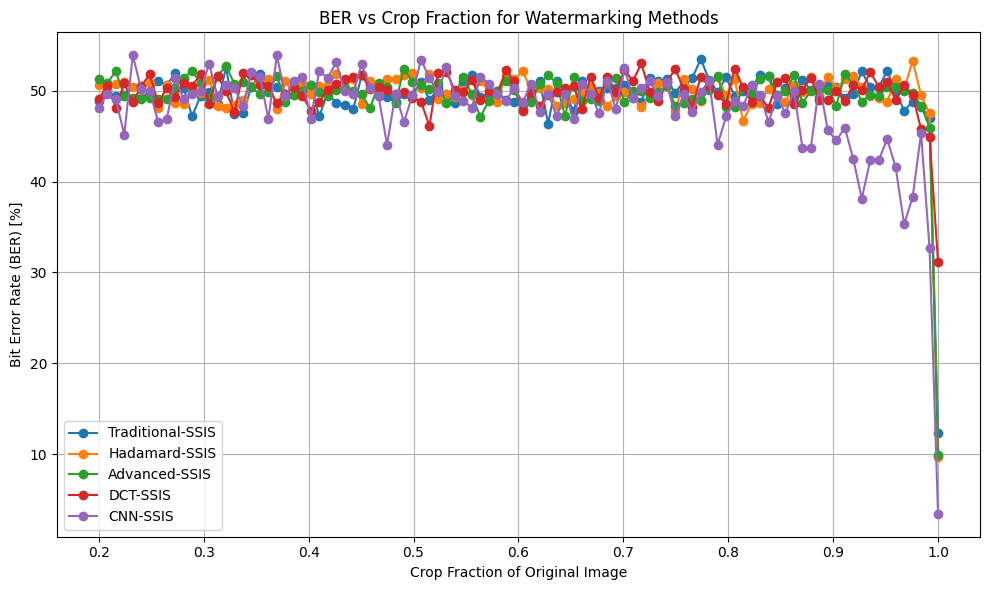

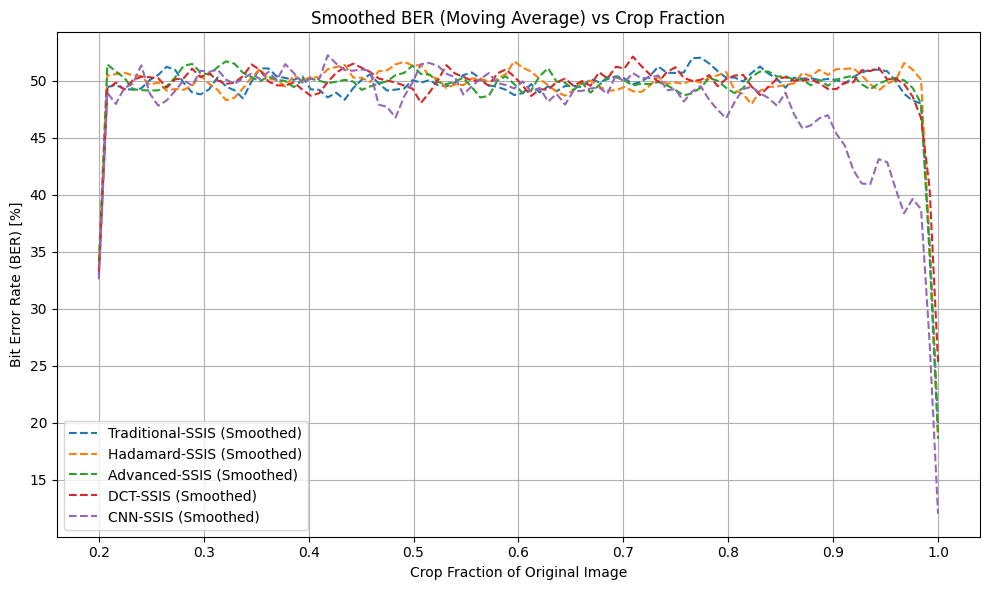

In [ ]:
# Parameters
iterations = 50
cnn_iterations = 20

crop_sizes = np.linspace(0.2, 1, 100)  # Crop fractions from 20% to 100%
ber_results = {
    "Traditional-SSIS": [],
    "Hadamard-SSIS": [],
    "Advanced-SSIS": [],
    "DCT-SSIS": [],
    "CNN-SSIS": []
}

# === SSIS METHODS (1: Traditional, 2: Hadamard, 3: Advanced, 4: DCT-SSIS) ===
for method_flag, method_name in zip([1, 2, 3, 4], list(ber_results.keys())[:4]):
    print(f"\nRunning crop attack experiment: {method_name}")

    for idx, crop_fraction in enumerate(crop_sizes):
        total_ber = 0

        for i in range(iterations):
            print(f"     Iteration {i+1}/{iterations}", end='\r')
            watermark_bits = np.random.choice([0, 1], size=32)

            index = np.random.randint(0, len(test_image_array))
            im = test_image_array[index]

            full_watermarked, pn_dict = complete_embedding(im, watermark_bits, method_flag)

            # Channel
            channel = Channel(full_watermarked)
            noisy_watermarked = channel.crop_image(crop_fraction)

            # Reconstruction based on method
            if method_flag == 4:
                reconstruction_bits = complete_dct_reconstruction(noisy_watermarked, pn_dict)
            else:
                reconstruction_bits = complete_reconstruction(noisy_watermarked, pn_dict)

            total_ber += calculate_ber(watermark_bits, reconstruction_bits)

        avg_ber = total_ber / iterations
        ber_results[method_name].append(avg_ber)
        print(f"→ Step {idx+1}/{len(crop_sizes)} | Crop Fraction = {crop_fraction:.2f} | Avg_BER = {avg_ber * 100:.2f}%")


# === CNN-BASED METHOD ===
print(f"\nRunning crop attack experiment: CNN-Based")
for idx, crop_fraction in enumerate(crop_sizes):
    total_ber = 0

    for i in range(cnn_iterations):
        print(f"     Iteration {i+1}/{cnn_iterations}", end='\r')
        watermark_bits = np.random.choice([0, 1], size=32)

        index = np.random.randint(0, len(test_image_array))
        im = test_image_array[index]

        full_watermarked = complete_CNN_embedding(im, watermark_bits, mask_ratio)

        # Channel
        channel = Channel(full_watermarked)
        noisy_watermarked = channel.crop_image(crop_fraction)

        reconstruction_bits = complete_CNN_reconstruction(noisy_watermarked, model)
        total_ber += calculate_ber(watermark_bits, reconstruction_bits)

    avg_ber = total_ber / cnn_iterations
    ber_results["CNN-SSIS"].append(avg_ber)
    print(f"→ Step {idx+1}/{len(crop_sizes)} | Crop Fraction = {crop_fraction:.2f} | Avg_BER = {avg_ber * 100:.2f}%")


# === BER PLOT ===
plt.figure(figsize=(10, 6))
for method_name, ber_list in ber_results.items():
    plt.plot(crop_sizes, np.array(ber_list) * 100, label=method_name, marker='o')

plt.title("BER vs Crop Fraction for Watermarking Methods")
plt.xlabel("Crop Fraction of Original Image")
plt.ylabel("Bit Error Rate (BER) [%]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# === SMOOTHED BER PLOT ===
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

plt.figure(figsize=(10, 6))
window_size = 3
for method_name, ber_list in ber_results.items():
    smoothed = moving_average(np.array(ber_list) * 100, window_size)
    plt.plot(crop_sizes, smoothed, label=f"{method_name} (Smoothed)", linestyle='--')

plt.title("Smoothed BER (Moving Average) vs Crop Fraction")
plt.xlabel("Crop Fraction of Original Image")
plt.ylabel("Bit Error Rate (BER) [%]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


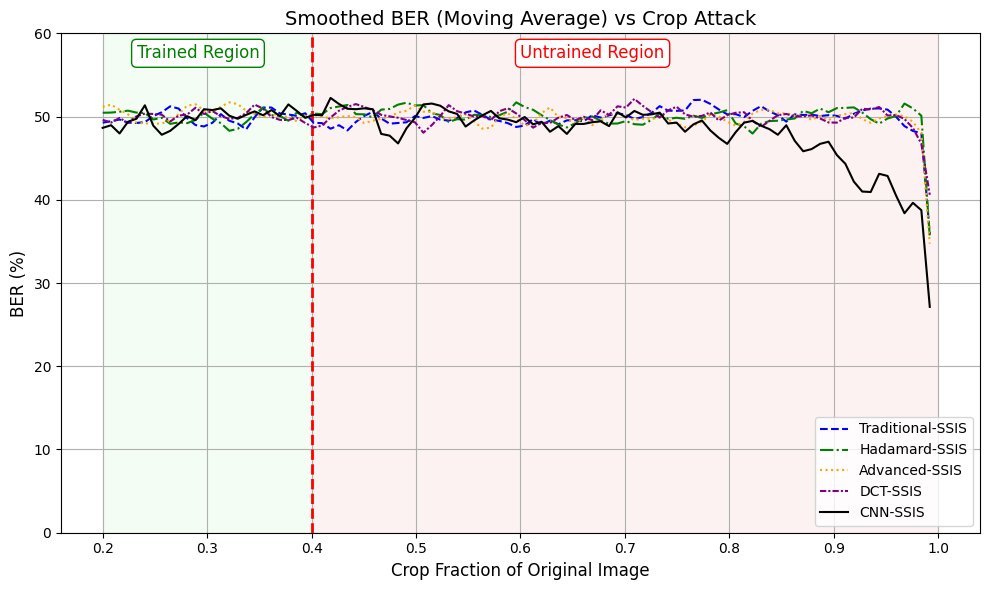

In [ ]:
from matplotlib.ticker import MaxNLocator

# === Enhanced Moving Average with edge padding ===
def moving_average(data, window_size=3):
    pad = window_size // 2
    padded = np.pad(data, (pad, pad), mode='edge')
    smoothed = np.convolve(padded, np.ones(window_size) / window_size, mode='valid')
    return smoothed[:-pad] if pad > 0 else smoothed

plt.figure(figsize=(10, 6))
window_size = 3

# Custom styles
line_styles = ['--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'green', 'orange', 'purple', 'teal']

# Background color regions (full width for untrained from 0.4 to end)
plt.axvspan(min(crop_sizes), 0.4, color='lightgreen', alpha=0.1, label='_nolegend_')  # Trained
plt.axvspan(0.4, max(crop_sizes), color='lightcoral', alpha=0.1, label='_nolegend_')  # Untrained

# Vertical split line
plt.axvline(x=0.4, color='red', linestyle='--', linewidth=2)

# Plot smoothed curves
for i, (method_name, ber_list) in enumerate(ber_results.items()):
    raw_data = np.array(ber_list) * 100
    smoothed = moving_average(raw_data, window_size)

    effective_len = len(smoothed)
    aligned_crop_sizes = crop_sizes[:effective_len]

    if "cnn" in method_name.lower():
        linestyle = '-'
        color = 'black'
    else:
        linestyle = line_styles[i % len(line_styles)]
        color = colors[i % len(colors)]

    plt.plot(aligned_crop_sizes, smoothed, label=method_name, linestyle=linestyle, color=color)

# Ticks and limits
plt.xticks(np.round(np.arange(min(crop_sizes), max(crop_sizes)+0.01, 0.1), 2))
plt.yticks(np.arange(0, 61, 10))
plt.ylim(0, 60)

# Region labels (positions retained)
plt.text(0.35, 57, "Trained Region", ha='right', fontsize=12, color='green',
         bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))
plt.text(0.6, 57, "Untrained Region", ha='left', fontsize=12, color='red',
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))

# Title and axis labels
plt.title("Smoothed BER (Moving Average) vs Crop Attack", fontsize=14)
plt.xlabel("Crop Fraction of Original Image", fontsize=12)
plt.ylabel("BER (%)", fontsize=12)
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# Transparency Test

In [ ]:
# # Embedding
# watermark_bits = np.random.choice([0, 1], size=32)
# full_watermarked, pn_dict = complete_embedding(im, watermark_bits, 3)

# # Channel
# channel = Channel(full_watermarked)
# noisy_watermarked = channel.add_random_noise(0.8)

# # Reconstruction
# reconstruction_bits = complete_reconstruction(noisy_watermarked, watermark_bits, pn_dict)


# plt.figure(figsize=(12, 12))
# plt.subplot(2, 3, 1)
# plt.imshow(im, cmap='gray')
# plt.title('Original Image')
# plt.axis('off')

# plt.subplot(2, 3, 2)
# plt.imshow(full_watermarked, cmap='gray')
# plt.title('Watermarked Image')
# plt.axis('off')

# plt.subplot(2, 3, 3)
# plt.imshow(noisy_watermarked, cmap='gray')
# plt.title('Noisy Watermarked Image')
# plt.axis('off')


# plt.subplot(2, 3, 4)
# plt.imshow(im - full_watermarked, cmap='gray')
# plt.title('im - watermarked')
# plt.axis('off')

# plt.subplot(2, 3, 5)
# plt.imshow(full_watermarked - noisy_watermarked, cmap='gray')
# plt.title('watermarked - noisy_watermarked')
# plt.axis('off')


# plt.tight_layout()
# plt.show()